# Search: Solving a Maze Using a Goal-based Agent

Student Name: Davis Lynn

I have used the following AI tools: ChatGPT for debugging BFS and printing tables and animations directly from code.

I understand that my submission needs to be my own work: DPL

## Learning Outcomes

* Formulate search problems using key components like initial state, actions, and goal state in a deterministic, fully observable environment.
* Implement and compare search algorithms including BFS, DFS, GBFS, A*, and IDS for planning paths through mazes.
* Analyze algorithm performance by measuring path cost, node expansions, depth, and memory usage across various maze types.
* Use visualization tools to represent maze paths and support debugging and analysis.

## Instructions

Total Points: Undergrads 100 + 5 bonus / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the notebook file and the completely rendered notebook with all outputs as a HTML file.


## Introduction

In this exercise, we will implement the planning function for a type of goal-based agent called a __planning agent__. The planning function uses a map it is given to plan a path through the maze from the starting location $S$ to the goal location $G$. We will only focus on the planning function, so you do not need to implement an environment, just use the map to search for a path to solve the maze.

Once the plan is made, the agent in a deterministic environment (i.e., the transition function is deterministic with the outcome of each state/action pair fixed and no randomness) can just follow the plan step-by-step and does not need to care about the percepts.
This is also called an **[open-loop system](https://en.wikipedia.org/wiki/Open-loop_controller).**
The execution phase is trivial and can be executed using a model-based reflex agent
that ignores all percepts and just follows the plan. I will show you a short example, but you do not implement it in this exercise.

Given that the agent has a complete and correct map, the environment is **fully observable, discrete, deterministic, and known.**
Remember:

* **Fully observable** means that the agent can see its state and what the available actions are. That means the **percepts contain the complete current state.**
Here, during planning, the agent always sees its x and y coordinates on the map and
also seeks when it has reached the goal state.
* **Discrete** means that we have a **finite set of states.** The maze has a finite set
of squares the agent can be in.
* **Deterministic** means that the **transition function contains no randomness.** An action in a state will always produce the same result. Going south from the start state always will lead to the same square.
* **Know** means that the agent **knows the complete transition function.** The
agent has the map and therefore knows how its position changes when it walks in a direction.

Tree search algorithm implementations that you find online typically come from data structures courses and have a different aim than AI tree search. These algorithms assume that you already have a tree in memory. We are interested in dynamically creating a search tree with the aim of finding a good/the best path from the root note to the goal state. Follow the pseudo code presented in the text book (and replicated in the slides) closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible.

Several mazes for this exercise are stored as text files. Here is the small example maze:

In [144]:
with open("Mazes/small_maze.txt", "r") as f:
    maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



**Note:** If you get an error here that the file cannot be found, then you need to download it. See [HOWTO Work on Assignments.](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/working_on_assignments.md)

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the module [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. Position are represented as a 2-tuple of the form `(row, col)`.

In [145]:
import maze_helper as mh

maze = mh.parse_maze(maze_str)

# look at a position in the maze by subsetting the 2d array
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)` available
# which uses a 2-tuple for the position.
print("Position(8,1):", mh.look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


A helper function to visualize the maze is also available.

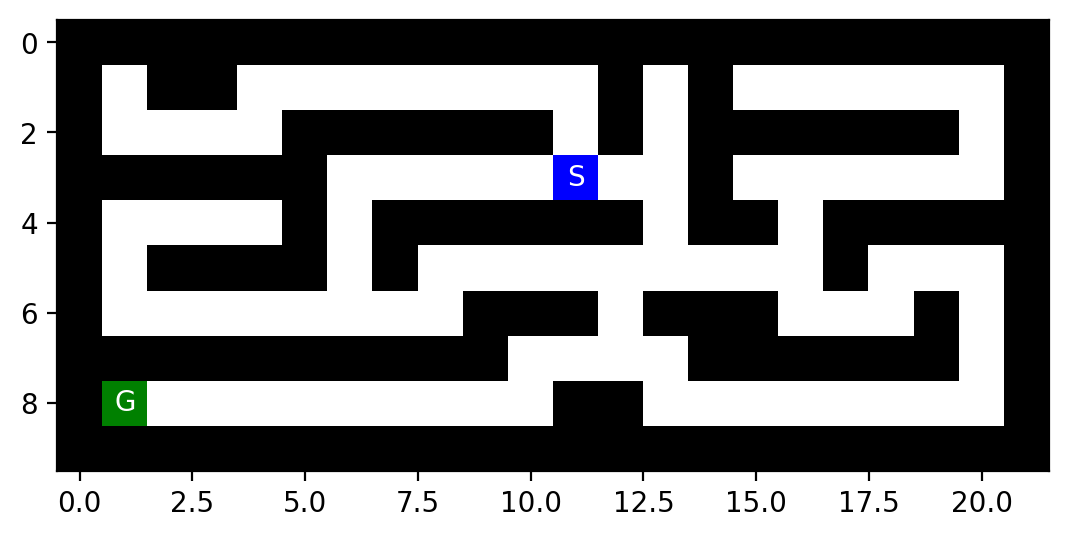

In [146]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebooks

mh.show_maze(maze)

Find the `(x,y)` position of the start and the goal using the helper function `find_pos()`

In [147]:
print("Start location:", mh.find_pos(maze, what = "S"))
print("Goal location:", mh.find_pos(maze, what = "G"))

Start location: (np.int64(3), np.int64(11))
Goal location: (np.int64(8), np.int64(1))


Helper function documentation.

In [148]:
help(mh)

Help on module maze_helper:

NAME
    maze_helper

DESCRIPTION
    Code for the Maze Assignment by Michael Hahsler
    Usage: 
        import maze_helper as mh
        mh.show_some_mazes()

FUNCTIONS
    animate_maze(result, repeat=False)
        (Experimental) Build an animation from a list of mazes. This needs ffmpeg to be installed.
        
        Parameters: 
            result: a list with the elements path, reached, actions and maze_anim with a list of maze arrays that contain what you want to visualize.
            repeat: if True, the animation will repeat.
    
    find_pos(maze, what='S')
        Find start/goal in a maze and returns the first one. 
        Caution: there is no error checking!
        
        Parameters:
            maze: a array with characters produced by parse_maze()
            what: the letter to be found ('S' for start and 'G' for goal)
        
        Returns:
            a tupple (x, y) for the found position.
    
    look(maze, pos)
        Look

You will need to make a local copy of the module file [maze_helper.py](maze_helper.py) in the same folder where your notebook is.

## An Example for a Planning Agent

I will show you here how to implement a simple agent that uses a random plan. It will not solve the maze, but show you how the mechanics work.

First, we define a generic planning agent that fist plans, and then executes the plan step-by-step.

In [149]:
class Planning_Agent:
    def __init__(self, maze, start, goal, planning_function):
        self.maze = maze
        self.start = start
        self.goal = goal
        self.planning_function = planning_function
        self.plan = None
        self.progress = None

    def act(self):
        # plan if no plan exists
        if self.plan is None:
            print("Planning...")
            self.plan = self.planning_function(self.maze, self.start, self.goal)
            self.progress = 0

        # check if plan is completed
        if self.progress >= len(self.plan):
            raise Exception("Completed Plan. No more planned actions")

        # follow the plan
        action = self.plan[self.progress]
        print(f"Following plan... step {self.progress}: {action}")

        self.progress += 1
        return action

Next, we define the planning function. This function is what you will implement in this assignment.  

In [150]:
import numpy as np

def plan_random(maze, start, goal):
    """Create a random plan with 10 steps"""
    plan = np.random.choice(["N", "E", "S", "W"], size=10, replace=True).tolist()
    return plan

plan_random(maze, (1,1), (8,8))

['S', 'S', 'S', 'N', 'N', 'S', 'W', 'E', 'E', 'S']

This planning function is not great and will not produce a plan that solves the maze. Your planning functions will do better.

Finally, we can create the planning agent, give it the planning function and implement a simple environment that asks it 11 times for an action.

In [151]:
my_agent = Planning_Agent(maze, mh.find_pos(maze, what = "S"), mh.find_pos(maze, what = "G"), plan_random)

def environment(agent_function, steps):
    for _ in range(steps):
        try:
            agent_function()
        except Exception as e:
            print(f"Agent exception: {e}")

environment(my_agent.act, steps=11)

Planning...
Following plan... step 0: W
Following plan... step 1: S
Following plan... step 2: W
Following plan... step 3: N
Following plan... step 4: E
Following plan... step 5: N
Following plan... step 6: W
Following plan... step 7: S
Following plan... step 8: W
Following plan... step 9: S
Agent exception: Completed Plan. No more planned actions


Note: The agent and environment implementation above is just an illustration. You will only implement and experiment with different versions of the planning function.

## Tree structure

To use tree search, you will need to implement a tree data structure in Python.
Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

In [152]:
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"

    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]

        while not node.parent is None:
            node = node.parent
            path.append(node)

        path.reverse()

        return(path)

If needed, then you can add more fields to the class like the heuristic value $h(n)$ or $f(n)$.

Examples for how to create and use a tree and information on memory management can be found [here](../HOWTOs/trees.ipynb).

# Tasks

The goal is to:

1. Implement the following search algorithms for solving different mazes:

    - Breadth-first search (BFS)
    - Depth-first search (DFS)
    - Greedy best-first search (GBFS)
    - A* search

2. Run each of the above algorithms on the
    - [small maze](small_maze.txt),
    - [medium maze](medium_maze.txt),
    - [large maze](large_maze.txt),
    - [open maze](open_maze.txt),
    - [L maze](L_maze.txt),
    - [loops maze](loops_maze.txt),
    - [empty maze](empty_maze.txt), and
    - [empty maze (rotated)](empty_maze_2.txt).
    
3. For each problem instance and each search algorithm, report the following in a table:

    - The solution and its path cost
    - Total number of nodes expanded
    - Maximum tree depth
    - Maximum size of the frontier

4. Display each solution by marking every maze square (or state) visited and the squares on the final path.

## General [10 Points]

1. Make sure that you use the latest version of this notebook.
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement intelligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formatted professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your submitted file is readable and contains all figures.
4. Document your code. Use comments in the code and add a discussion of how your implementation works and your design choices.

## Task 1: Defining the search problem and determining the problem size [10 Points]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

Use verbal descriptions, variables and equations as appropriate.

*Note:* You can swich the next block from code to Markdown and use formating.


* Initial state
    - The starting point of the maze, a known point within a nxm set of values. 
* Actions
    - The agent can move N,S,E,W based on its position, but cannot overlap with walls, marked by an X. The agent can only move one square at a time, meaning it cannot jump over other objects.
* Transition model
    - Result(South) = (X+1,Y)
    - Result(North) = (X-1,Y)
    - Result(East) = (X,Y-1)
    - Result(West) = (X,Y+1)

* Goal state
    - The agent must traverse the maze to reach the end goal coordinate within the maze. This end goal is static, and must be reached using the rules assigned in the above actions section.
* Path cost
    - The cost of the agent is the number of steps needed to reach the goal coordinate, a more efficient algorithm requires less steps to solve the maze.

## Task 2: Uninformed search: Breadth-first and depth-first [40 Points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

Read the following **important notes** carefully:
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and **do not store information in the map.** Only store information in the tree created during search, and use the `reached` and `frontier` data structures where appropriate.
* DSF behavior can be implemented using the BFS tree search algorithm and simply changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, this would be a big mistake since it combines the bad space complexity of BFS with the bad time complexity of DFS! **To take advantage of the significantly smaller memory footprint of DFS, you need to implement DFS in a different way without a `reached` data structure (often also called `visited` or `explored`) and by releasing the memory for nodes that are not needed anymore.**
* Since the proper implementation of DFS does not use a `reached` data structure, redundant path checking abilities are limited to cycle checking.
You need to implement **cycle checking since DSF is incomplete (produces an infinite loop) if cycles cannot be prevented.** You will see in your experiments that cycle checking in open spaces is challenging.

In [153]:
directions = ["N", "E", "S", "W"]

def expand_node(node, maze):
    current = node.pos
    children = []
    for direction in directions:
        match direction: #switch case to change position based on directions
            case "N":
                #print("North")
                new_pos = (current[0] - 1, current[1])
            case "E":
                new_pos = (current[0], current[1] + 1)
                #print("East")
            case "S":
                #print("South")
                new_pos = (current[0] + 1, current[1])
            case "W":
                #print("West")
                new_pos = (current[0], current[1] - 1)

        if mh.look(maze, new_pos) != "X": # not a wall
            #print(f"Valid move to {new_pos}")
            children.append((direction, new_pos))
        else:
            #print(f"Invalid move to {new_pos}")
            pass
    return children


In [ ]:
def show_final_from_path(maze, animation_path, fontsize=10):
# prints the maze with the path taken marked with 'P'
    m = np.copy(maze) # make a copy to not overwrite original
    for (r, c) in animation_path: 
        if mh.look(m, (r, c)) not in ('S', 'G', 'X'): # only change empty spaces
            m[r, c] = 'P' # changing path on copy to 'P'
    mh.show_maze(m, fontsize=fontsize)


In [155]:



def breadth_first_search(maze):
    start = mh.find_pos(maze, what = "S")
    goal = mh.find_pos(maze, what = "G")
    start_node = Node(start, None, None, 0)
    
    frontier = [start_node]
    reached = {start_node.pos}
    
    number_of_nodes_expanded = 0
    max_depth = 0 
    max_frontier = 0
    max_in_memory = 0
    animation_path = []  # coordinates of final path for animation
    while not len(frontier) == 0: # while frontier is not empty
        node = frontier.pop(0)  # FIFO queue for BFS

        for child in expand_node(node, maze): #for each child node that is expanded
                action = child[0] # direction
                child_node = child[1] # position (row,col)
                s=Node(child_node, node, action, cost = node.cost + 1)
                number_of_nodes_expanded += 1
                p= s.get_path_from_root()
                path = [n.action for n in p]
                if len(path) > max_depth:
                        max_depth = len(path)
                if child_node == goal:
                     cost = node.cost # path cost for solution
                     animation_path.extend([n.pos for n in p])
                     return path, cost, number_of_nodes_expanded, max_depth, max_frontier, max_in_memory,animation_path
                if not child_node in reached:
                        reached.add(child_node) # add to reached set
                        frontier.append(s) # add to frontier
                if (len(reached) + len([n.pos for n in frontier])) > max_in_memory:
                    max_in_memory = len(reached) + len([n.pos for n in frontier])
                if len(frontier) > max_frontier:
                        max_frontier = len(frontier) # update max frontier size
    print("No solution found") # Worst Case, should not trigger
    return None #Worst Case, should not trigger


In [156]:
def check_cycle(node):
    reached = node.get_path_from_root()[:-1]  # all ancestors
    if node.pos in [n.pos for n in reached]:
        return True
    return False


In [ ]:
def depth_first_search(maze):
    start = mh.find_pos(maze, what="S") #initializes head, start, and goal positions
    goal  = mh.find_pos(maze, what="G")
    start_node = Node(start, parent=None, action=None, cost=0)

    frontier = [start_node]  # LIFO stack

    # Stats
    num_expanded = 0            # count parents expanded (per pop)
    max_depth = 0               # measured in edges from root (root depth = 0)
    max_frontier = 0
    max_in_memory = 0
    animation_path = []  # coordinates of final path for animation

    # Early exit if start is goal
    if start == goal:
        p = start_node.get_path_from_root()
        path_actions = [n.action for n in p if n.action]
        cost = start_node.cost
        return path_actions, cost, num_expanded, max_depth, max_frontier, max_in_memory

    while frontier:
        node = frontier.pop()

        if node.pos == goal:
            p = node.get_path_from_root()
            path_actions = [n.action for n in p if n.action]
            cost = node.cost
            animation_path.extend([n.pos for n in p])

            return path_actions, cost, num_expanded, max_depth, max_frontier, max_in_memory,animation_path

        num_expanded += 1 #expanding parent node

        child_nodes = []
        local_max_child_depth = 0

        for action, child_pos in expand_node(node, maze):
            s = Node(child_pos, node, action, cost=node.cost + 1)

            #check for cycles before adding to child nodes
            if check_cycle(s):
                continue

            # Track depth using path length minus 1 (edges)
            depth_s = len(s.get_path_from_root()) - 1
            if depth_s > local_max_child_depth:
                local_max_child_depth = depth_s

            child_nodes.append(s)

        if child_nodes:
            # Remove any existing frontier nodes that duplicate the new children by position
            children_pos = {c.pos for c in child_nodes}
            frontier = [n for n in frontier if n.pos not in children_pos] + child_nodes

            # Update stats after the batch merge
            max_depth = max(max_depth, local_max_child_depth)
            max_frontier = max(max_frontier, len(frontier))
            max_in_memory = max(max_in_memory, len(frontier))

    return "failure" # no solution found, should not trigger


Path to goal: [None, 'E', 'E', 'S', 'S', 'W', 'S', 'S', 'W', 'W', 'S', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W']
Cost of path: 18
Number of nodes expanded: 185
Max depth reached: 20
Max size of frontier: 9
Max nodes in memory: 95


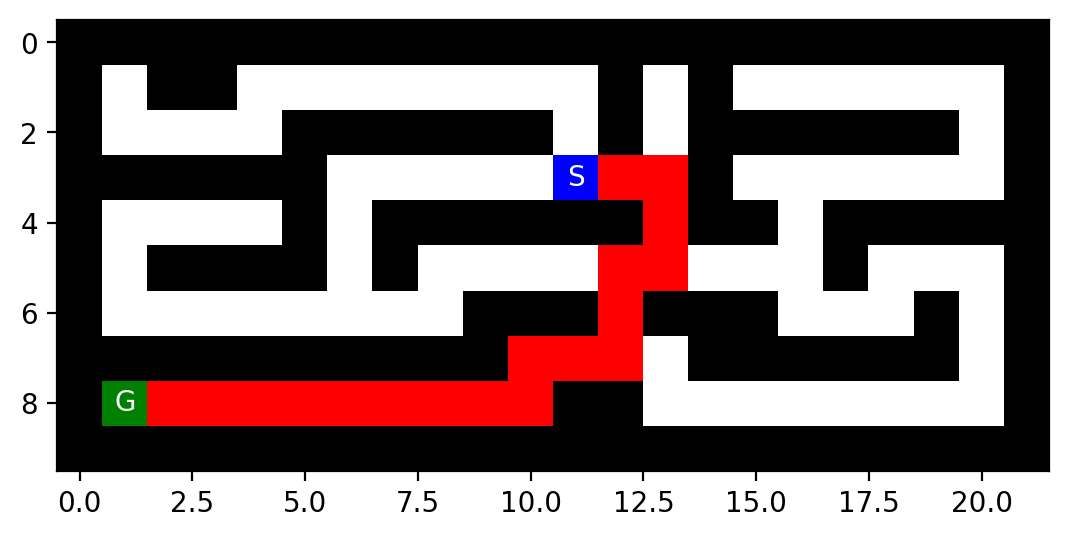

In [158]:
#test BFS

f = open("Mazes/small_maze.txt", "r")
maze_str = f.read()
maze = mh.parse_maze(maze_str)
result_path, result_cost, result_num_expanded, result_max_depth, result_max_frontier, result_max_memory,result_animation = breadth_first_search(maze)
print("Path to goal:", result_path)
print("Cost of path:", result_cost)
print("Number of nodes expanded:", result_num_expanded)
print("Max depth reached:", result_max_depth)
print("Max size of frontier:", result_max_frontier)
print("Max nodes in memory:", result_max_memory)
show_final_from_path(maze,result_animation)

DFS Results:
Path to goal: ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'S', 'S', 'S']
Path cost: 54
Number of nodes expanded: 211
Max depth reached: 178
Max nodes in memory: 64
Max size of frontier: 64


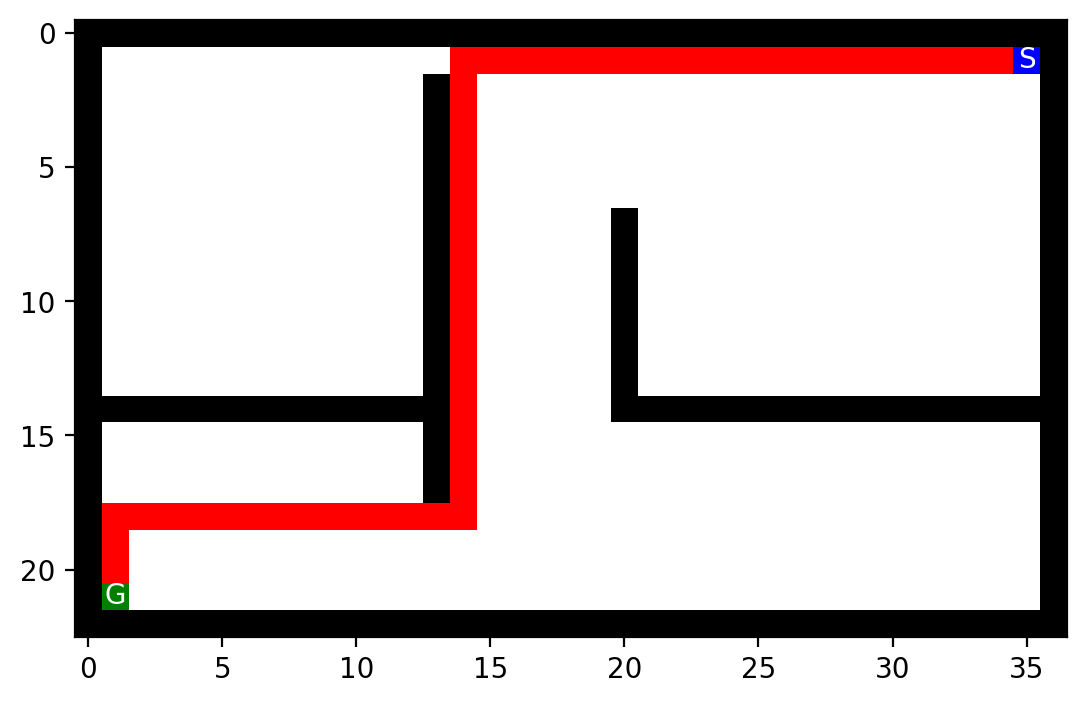

In [159]:
# Test DFS on a sample maze
f = open("Mazes/open_maze.txt", "r")
maze_str = f.read()
f.close()

maze = mh.parse_maze(maze_str)

# Run DFS with full stats output
result = depth_first_search(maze)

if result == 'failure' or result is None:
    print("No path found.")
else:
    path,result_cost, result_num_expanded, result_max_depth, result_max_memory, result_max_frontier,result_animation = result
    print("DFS Results:")
    print(f"Path to goal: {path}")
    print(f"Path cost: {result_cost}")
    print(f"Number of nodes expanded: {result_num_expanded}")
    print(f"Max depth reached: {result_max_depth}")
    print(f"Max nodes in memory: {result_max_memory}")
    print(f"Max size of frontier: {result_max_frontier}")
    show_final_from_path(maze,result_animation)

**How does BFS and DFS (without a reached data structure) deal with loops (cycles)?**

In BFS, my algorithm keeps a log of expanded nodes, and compares against that log. This ensures there will be no cycles generated, as it invalidates potential moves that would cause a cycle. 

In DFS, my algorithm checks for cycles by checking for a searched node reoccuring in the parent nodes of the searched node. If this is true, there is a cycle present within the tree structure. However, this does require additional computation node to check for cycles.

**Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations? Especially discuss the difference in space complexity between BFS and DFS.**

Both implementations are complete, as are all other solving algorithms for this problem due to the finite space size. 

BFS is optimal, as it will find a optimal solution upon every running of the program. The time and space complexity of BFS is O(b^d) where b is the number of successor nodes, and d is the depth of the search. BFS will replicate this complexity on every runtime.

DFS is not optimal, as it will provide the first solution it finds. The time complexity of DFS is O(b^m) but the space complexity is O(bm), which makes it better for larger problems due to the reduced memory burden. 

## Task 3: Informed search: Implement greedy best-first search and A* search  [20 Points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides).

In [ ]:
def manhattan_distance(pos, goal):
    return abs(pos[0] - goal[0]) + abs(pos[1] - goal[1])

def greedy_best_first_search(maze):
    start_state = mh.find_pos(maze, what="S")
    goal_state = mh.find_pos(maze, what="G")
    start_node = Node(start_state, None, None, 0)
    frontier = [start_node]
    reached = {start_node.pos}
    number_of_nodes_expanded = 0
    max_depth = 0
    max_frontier = 0
    max_in_memory = 0
    animation_path = []  # coordinates of final path for animation

    while frontier:
        # Compute heuristic for each node in frontier
        frontier_heuristic = [(manhattan_distance(n.pos, goal_state), n) for n in frontier]
        frontier_heuristic.sort(key=lambda x: x[0])
        node = frontier_heuristic[0][1]
        frontier.remove(node)

        if node.pos == goal_state: # test if goal is met
            p = node.get_path_from_root()
            path = [n.action for n in p if n.action]
            cost = node.cost
            animation_path.extend([n.pos for n in p]) # Append final path (positions) to animation_path
            return path, cost, number_of_nodes_expanded, max_depth, max_frontier, max_in_memory, animation_path

        for action, child_pos in expand_node(node, maze):
            s = Node(child_pos, node, action, cost=node.cost + 1)
            number_of_nodes_expanded += 1
            p = s.get_path_from_root()
            path = [n.action for n in p]

            if len(frontier) + len(reached) > max_in_memory: # update max in memory
                max_in_memory = len(frontier) + len(reached)
            if len(path) > max_depth:
                max_depth = len(path)

            if child_pos not in reached: ## if frontier and reached do not already contain child, add child positions
                reached.add(child_pos)
                frontier.append(s)
                if len(frontier) > max_frontier:
                    max_frontier = len(frontier)

    print("No solution found") # Worst Case, should not trigger
    return None


In [161]:
def a_star_search(maze):
    start_state = mh.find_pos(maze, what = "S")
    goal_state = mh.find_pos(maze, what = "G")
    start_node = Node(start_state, None, None, 0)
    frontier = [start_node]
    reached = {start_node.pos}
    number_of_nodes_expanded = 0
    max_depth = 0
    max_frontier = 0
    max_in_memory = 0
    animation_path = []  # coordinates of final path for animation

    while not len(frontier) == 0: # while frontier is not empty
        frontier_heuristic = []
        for node in frontier:
            g = node.cost
            h = manhattan_distance(node.pos, goal_state)
            f = g + h
            frontier_heuristic.append((f, node))
        frontier_heuristic.sort(key=lambda x: x[0]) # sort by f value
        node = frontier_heuristic[0][1] # get node with lowest f value
        frontier.remove(node) # remove node from frontier
        if node.pos == goal_state:
            p= node.get_path_from_root()
            path = [n.action for n in p]
            cost = node.cost # path cost for solution
            animation_path.extend([n.pos for n in p])
            return path, cost, number_of_nodes_expanded, max_depth, max_frontier, max_in_memory,animation_path
        for child in expand_node(node, maze): #for each child node that is expanded
            action = child[0] # direction
            child_node = child[1] # position (row,col)
            s=Node(child_node, node, action, cost = node.cost + 1) # create new node, increase cost by 1 
            number_of_nodes_expanded += 1
            p= s.get_path_from_root() 
            path = [n.action for n in p]
            if len(frontier) + len(reached)> max_in_memory:
                    max_in_memory = len(frontier)+ len(reached) # update max in memory
            if len(path) > max_depth:
                    max_depth = len(path) # update max depth
            if not child_node in reached:
                    reached.add(child_node) # add to reached set
                    frontier.append(s) # add to frontier
                    if len(frontier) > max_frontier:
                            max_frontier = len(frontier) # update max frontier size
    print("No solution found") # Worst Case, should not trigger
    return None #Worst Case, should not trigger

Path to goal: ['W', 'W', 'W', 'W', 'W', 'S', 'S', 'S', 'E', 'E', 'N', 'E', 'E', 'E', 'E', 'S', 'S', 'W', 'W', 'S', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W']
Cost of path: 29
Number of nodes expanded: 81
Max depth reached: 30
Max size of frontier: 5
Max nodes in memory: 47


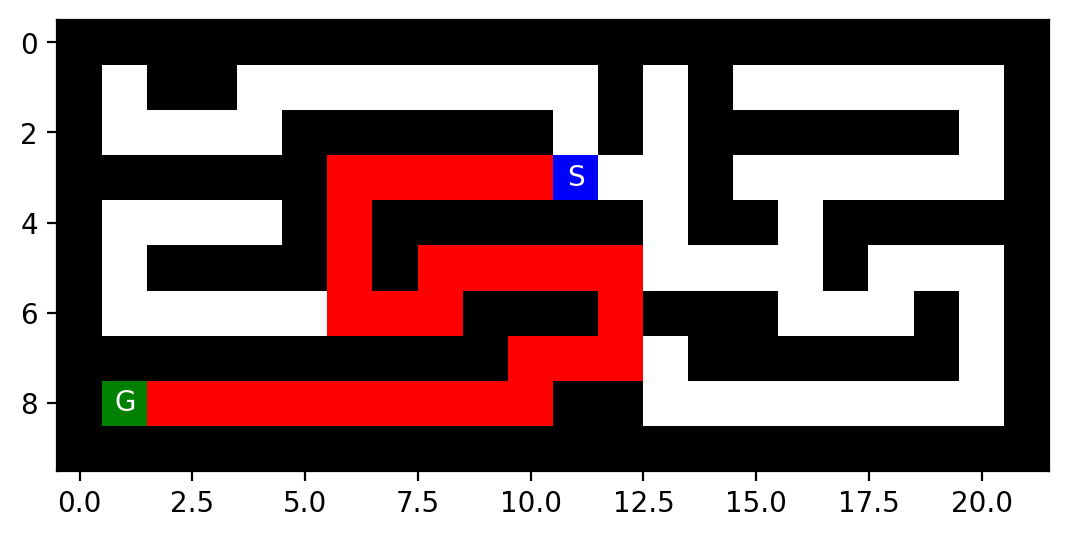

In [162]:
#Greedy Best First Search Test
f = open("Mazes/small_maze.txt", "r")
maze_str = f.read()
maze = mh.parse_maze(maze_str)
result_path, result_cost, result_num_expanded, result_max_depth, result_max_frontier, result_max_memory,result_animation = greedy_best_first_search(maze)
print("Path to goal:", result_path)
print("Cost of path:", result_cost)
print("Number of nodes expanded:", result_num_expanded)
print("Max depth reached:", result_max_depth)
print("Max size of frontier:", result_max_frontier)
print("Max nodes in memory:", result_max_memory)
show_final_from_path(maze,result_animation)

Path to goal: [None, 'E', 'E', 'S', 'S', 'W', 'S', 'S', 'W', 'W', 'S', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W']
Cost of path: 19
Number of nodes expanded: 110
Max depth reached: 20
Max size of frontier: 8
Max nodes in memory: 64


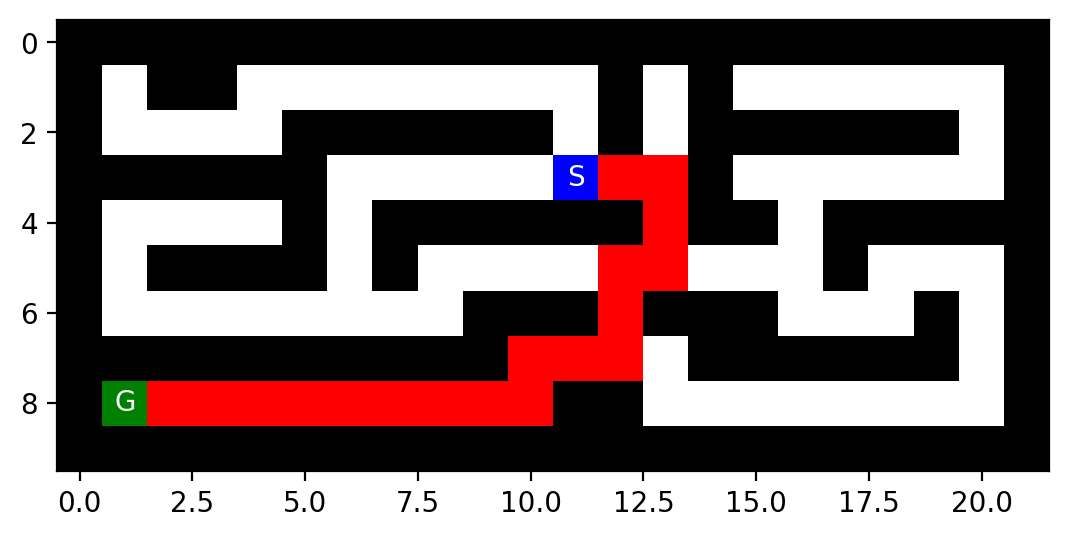

In [163]:
# A* Search Test
f = open("Mazes/small_maze.txt", "r")
maze_str = f.read()
maze = mh.parse_maze(maze_str)
result_path, result_cost, result_num_expanded, result_max_depth, result_max_frontier, result_max_memory,result_animation = a_star_search(maze)
print("Path to goal:", result_path)
print("Cost of path:", result_cost)
print("Number of nodes expanded:", result_num_expanded)
print("Max depth reached:", result_max_depth)
print("Max size of frontier:", result_max_frontier)
print("Max nodes in memory:", result_max_memory)
show_final_from_path(maze,result_animation)


**Are your implementations complete and optimal? What is the time and space complexity?**

- GBFS is a complete algorithm, but it is not optimal and will return the first solution it sees. The worst case scenario of both space and time complexity is O(b^m) and a best case scenario of O(bm).
- A* search is complete and optimal, with a space and time complexity of O(b^d). However, it will reach fewer nodes than a BFS algorithm due to the heuristic reducing the number of nodes needed to be seen by the algorithm. 

## Task 4: Comparison and discussion [20 Points]

Run experiments to compare the implemented algorithms.

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug (likely your frontier and cycle checking for DFS are the issue). If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.

In [178]:
import pandas as pd
from IPython.display import display, Markdown

runs = 100  # number of runs per maze

algorithms = ["bfs", "dfs", "gbfs", "astar"]
maze_files = {
    "small": "Mazes/small_maze.txt",
    "medium": "Mazes/medium_maze.txt",
    "large": "Mazes/large_maze.txt",
    "loops": "Mazes/loops_maze.txt",
    "empty": "Mazes/empty_maze.txt",
    "empty2": "Mazes/empty_maze_2.txt",
    "open": "Mazes/open_maze.txt",
    "L": "Mazes/L_maze.txt"
}

results = {alg: [0, 0, 0, 0, 0] for alg in algorithms}
averages = {size: {alg: [] for alg in algorithms} for size in maze_files.keys()}

    # Function to run all algorithms on a given maze and update results
def run_all_algorithms(maze, results_dict, averages_dict):
    funcs = {
        "bfs": breadth_first_search,
        "dfs": depth_first_search,
        "gbfs": greedy_best_first_search,
        "astar": a_star_search
    }
    for name, func in funcs.items():
        path, cost, expanded, depth, frontier, memory,solution = func(maze)
        results_dict[name][0] += cost
        results_dict[name][1] += expanded
        results_dict[name][2] += depth
        results_dict[name][3] += memory
        results_dict[name][4] += frontier
        averages_dict[name].append((cost, expanded, depth, memory, frontier))


# Run all mazes and display results
for size, file in maze_files.items():
    print(f"\nRunning {size.capitalize()} Maze...")
    results = {alg: [0, 0, 0, 0, 0] for alg in algorithms}
    
    for i in range(runs):
        with open(file, "r") as f:
            maze = mh.parse_maze(f.read())
        run_all_algorithms(maze, results, averages[size])

    #adds dataframe for each maze    
    df = pd.DataFrame({
        "algorithm": [alg.upper() for alg in algorithms],
        "path cost": [results[alg][0] / runs for alg in algorithms],
        "# nodes expanded": [results[alg][1] / runs for alg in algorithms],
        "max tree depth": [results[alg][2] / runs for alg in algorithms],
        "max nodes in memory": [results[alg][3] / runs for alg in algorithms],
        "max frontier size": [results[alg][4] / runs for alg in algorithms],
    })
    
    # Round to 2 decimals
    df = df.round(2)
    
    # Print as a markdown title + formatted dataframe
    display(Markdown(f"### __{size.capitalize()} Maze__"))
    display(df.style.set_table_attributes("style='display:inline'").set_caption(f"{size.capitalize()} Maze Results"))



Running Small Maze...


### __Small Maze__

,algorithm,path cost,# nodes expanded,max tree depth,max nodes in memory,max frontier size
0,BFS,18.000000,185.000000,20.000000,95.000000,9.000000
1,DFS,29.000000,39.000000,29.000000,5.000000,5.000000
2,GBFS,29.000000,81.000000,30.000000,47.000000,5.000000
3,ASTAR,19.000000,110.000000,20.000000,64.000000,8.000000



Running Medium Maze...


### __Medium Maze__

,algorithm,path cost,# nodes expanded,max tree depth,max nodes in memory,max frontier size
0,BFS,67.000000,547.000000,69.000000,272.000000,9.000000
1,DFS,152.000000,153.000000,152.000000,8.000000,8.000000
2,GBFS,74.000000,160.000000,75.000000,84.000000,4.000000
3,ASTAR,68.000000,453.000000,69.000000,233.000000,8.000000



Running Large Maze...


### __Large Maze__

,algorithm,path cost,# nodes expanded,max tree depth,max nodes in memory,max frontier size
0,BFS,209.000000,1238.000000,211.000000,625.000000,8.000000
1,DFS,210.000000,337.000000,214.000000,38.000000,38.000000
2,GBFS,210.000000,951.000000,211.000000,506.000000,21.000000
3,ASTAR,210.000000,1104.000000,211.000000,563.000000,12.000000



Running Loops Maze...


### __Loops Maze__

,algorithm,path cost,# nodes expanded,max tree depth,max nodes in memory,max frontier size
0,BFS,22.000000,182.000000,24.000000,73.000000,8.000000
1,DFS,27.000000,30.000000,27.000000,11.000000,11.000000
2,GBFS,23.000000,137.000000,24.000000,69.000000,10.000000
3,ASTAR,23.000000,157.000000,24.000000,66.000000,6.000000



Running Empty Maze...


### __Empty Maze__

,algorithm,path cost,# nodes expanded,max tree depth,max nodes in memory,max frontier size
0,BFS,13.000000,333.000000,15.000000,99.000000,12.000000
1,DFS,80.000000,80.000000,80.000000,12.000000,12.000000
2,GBFS,14.000000,56.000000,15.000000,72.000000,29.000000
3,ASTAR,14.000000,252.000000,15.000000,125.000000,31.000000



Running Empty2 Maze...


### __Empty2 Maze__

,algorithm,path cost,# nodes expanded,max tree depth,max nodes in memory,max frontier size
0,BFS,13.000000,335.000000,15.000000,99.000000,11.000000
1,DFS,34.000000,34.000000,34.000000,32.000000,32.000000
2,GBFS,14.000000,56.000000,15.000000,70.000000,29.000000
3,ASTAR,14.000000,252.000000,15.000000,123.000000,31.000000



Running Open Maze...


### __Open Maze__

,algorithm,path cost,# nodes expanded,max tree depth,max nodes in memory,max frontier size
0,BFS,53.000000,2509.000000,55.000000,687.000000,25.000000
1,DFS,54.000000,211.000000,178.000000,64.000000,64.000000
2,GBFS,68.000000,293.000000,69.000000,219.000000,66.000000
3,ASTAR,54.000000,1985.000000,55.000000,575.000000,25.000000



Running L Maze...


### __L Maze__

,algorithm,path cost,# nodes expanded,max tree depth,max nodes in memory,max frontier size
0,BFS,15.000000,513.000000,17.000000,156.000000,17.000000
1,DFS,122.000000,132.000000,122.000000,23.000000,23.000000
2,GBFS,24.000000,118.000000,25.000000,82.000000,25.000000
3,ASTAR,16.000000,194.000000,17.000000,105.000000,26.000000


Present the results as using charts (see [Python Code Examples/charts and tables](../HOWTOs/charts_and_tables.ipynb)).

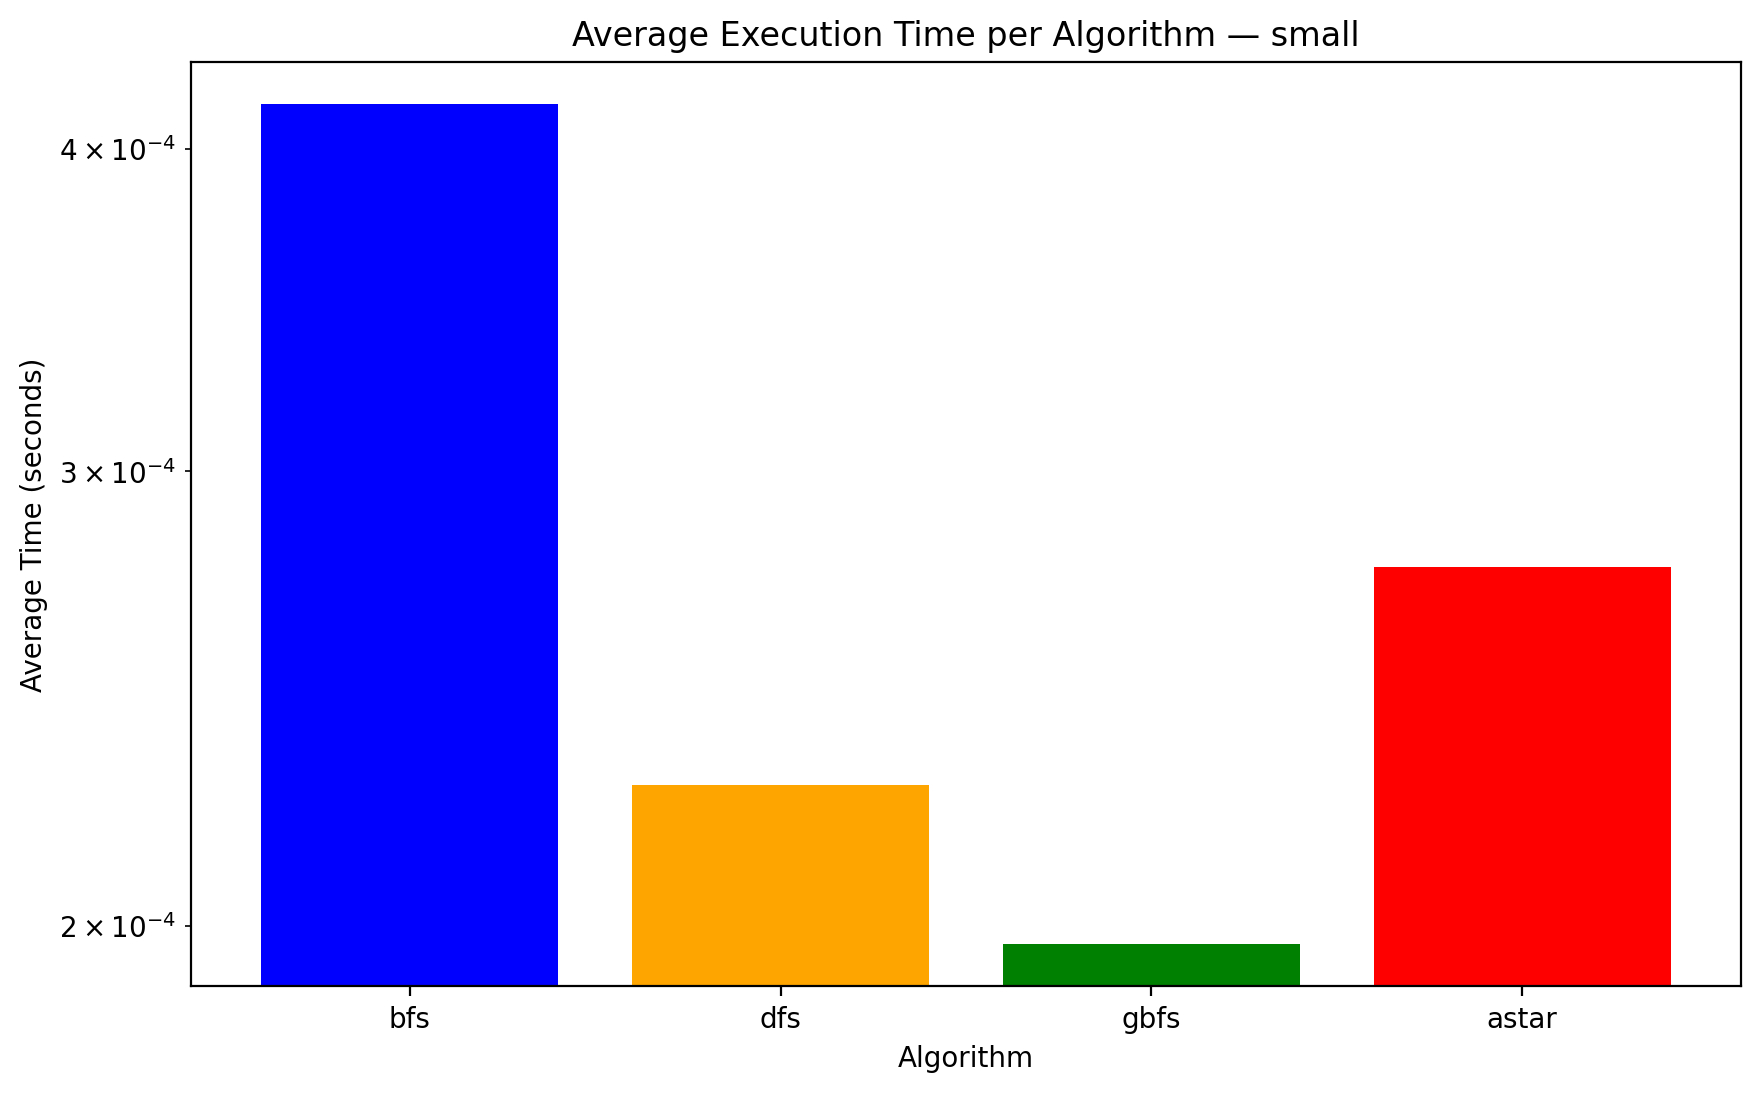

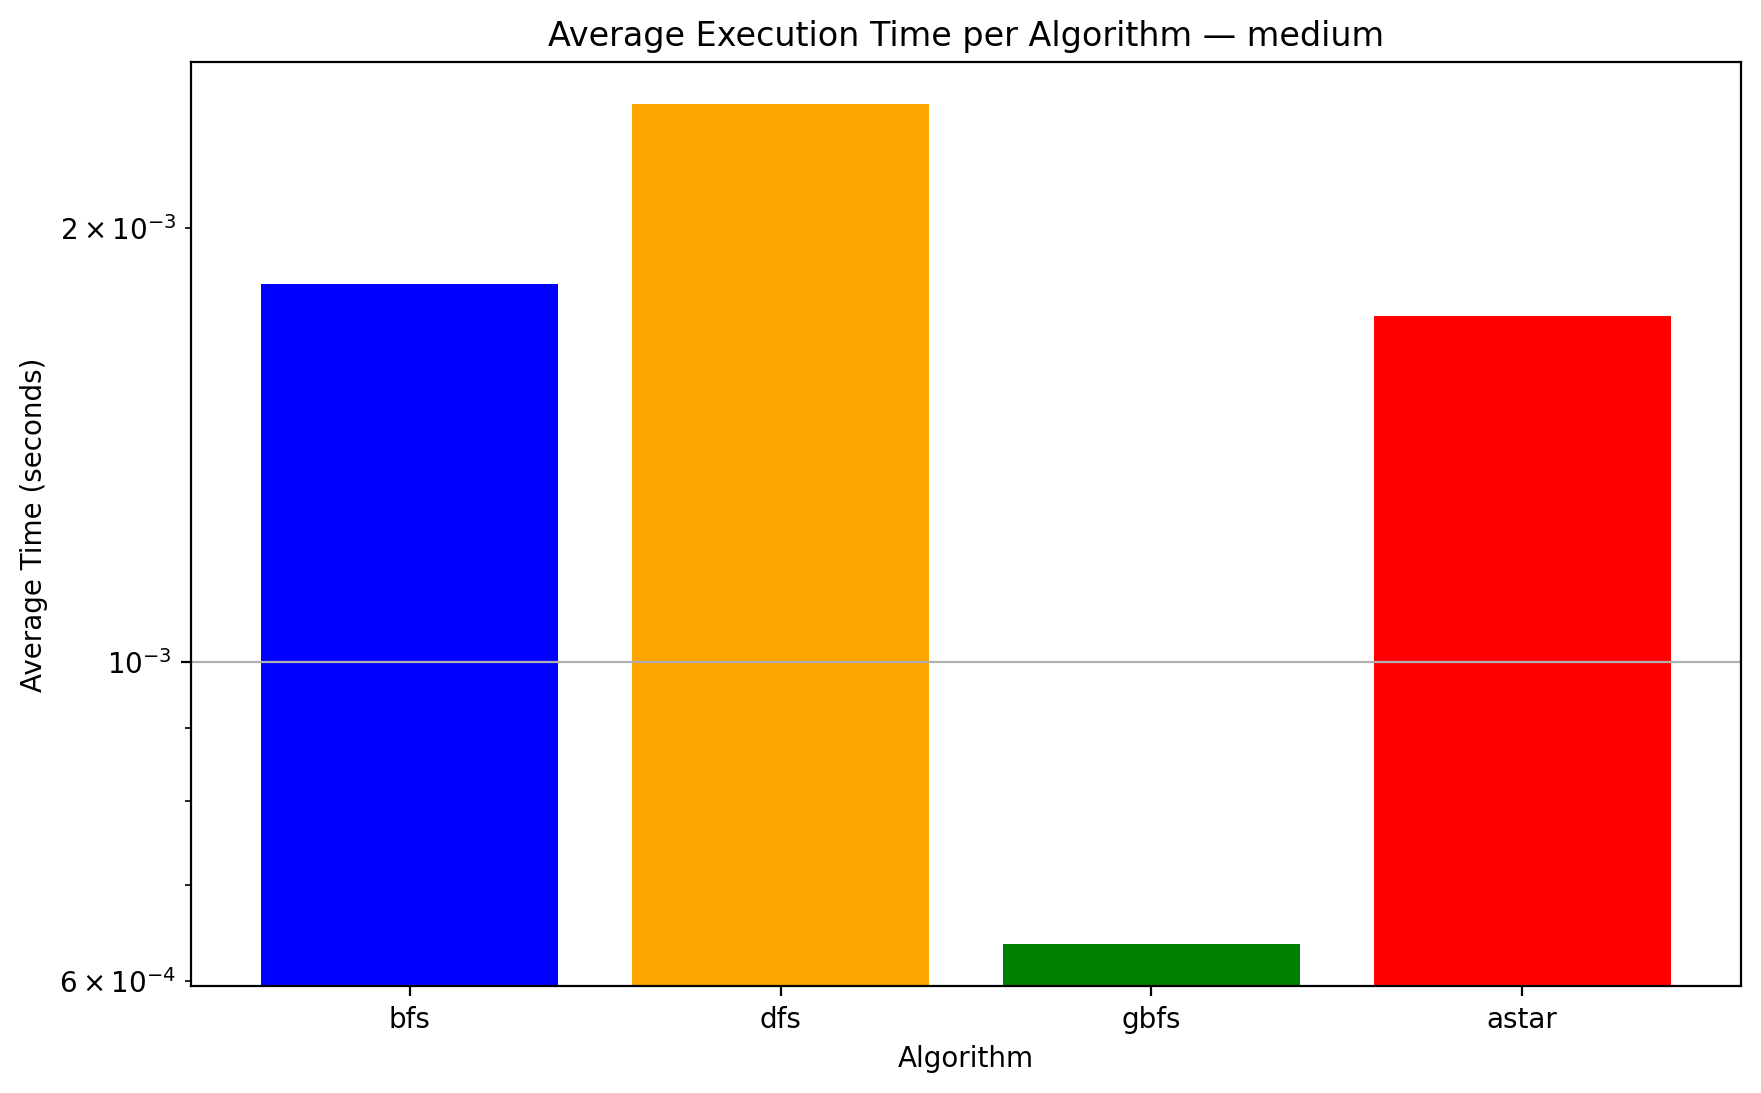

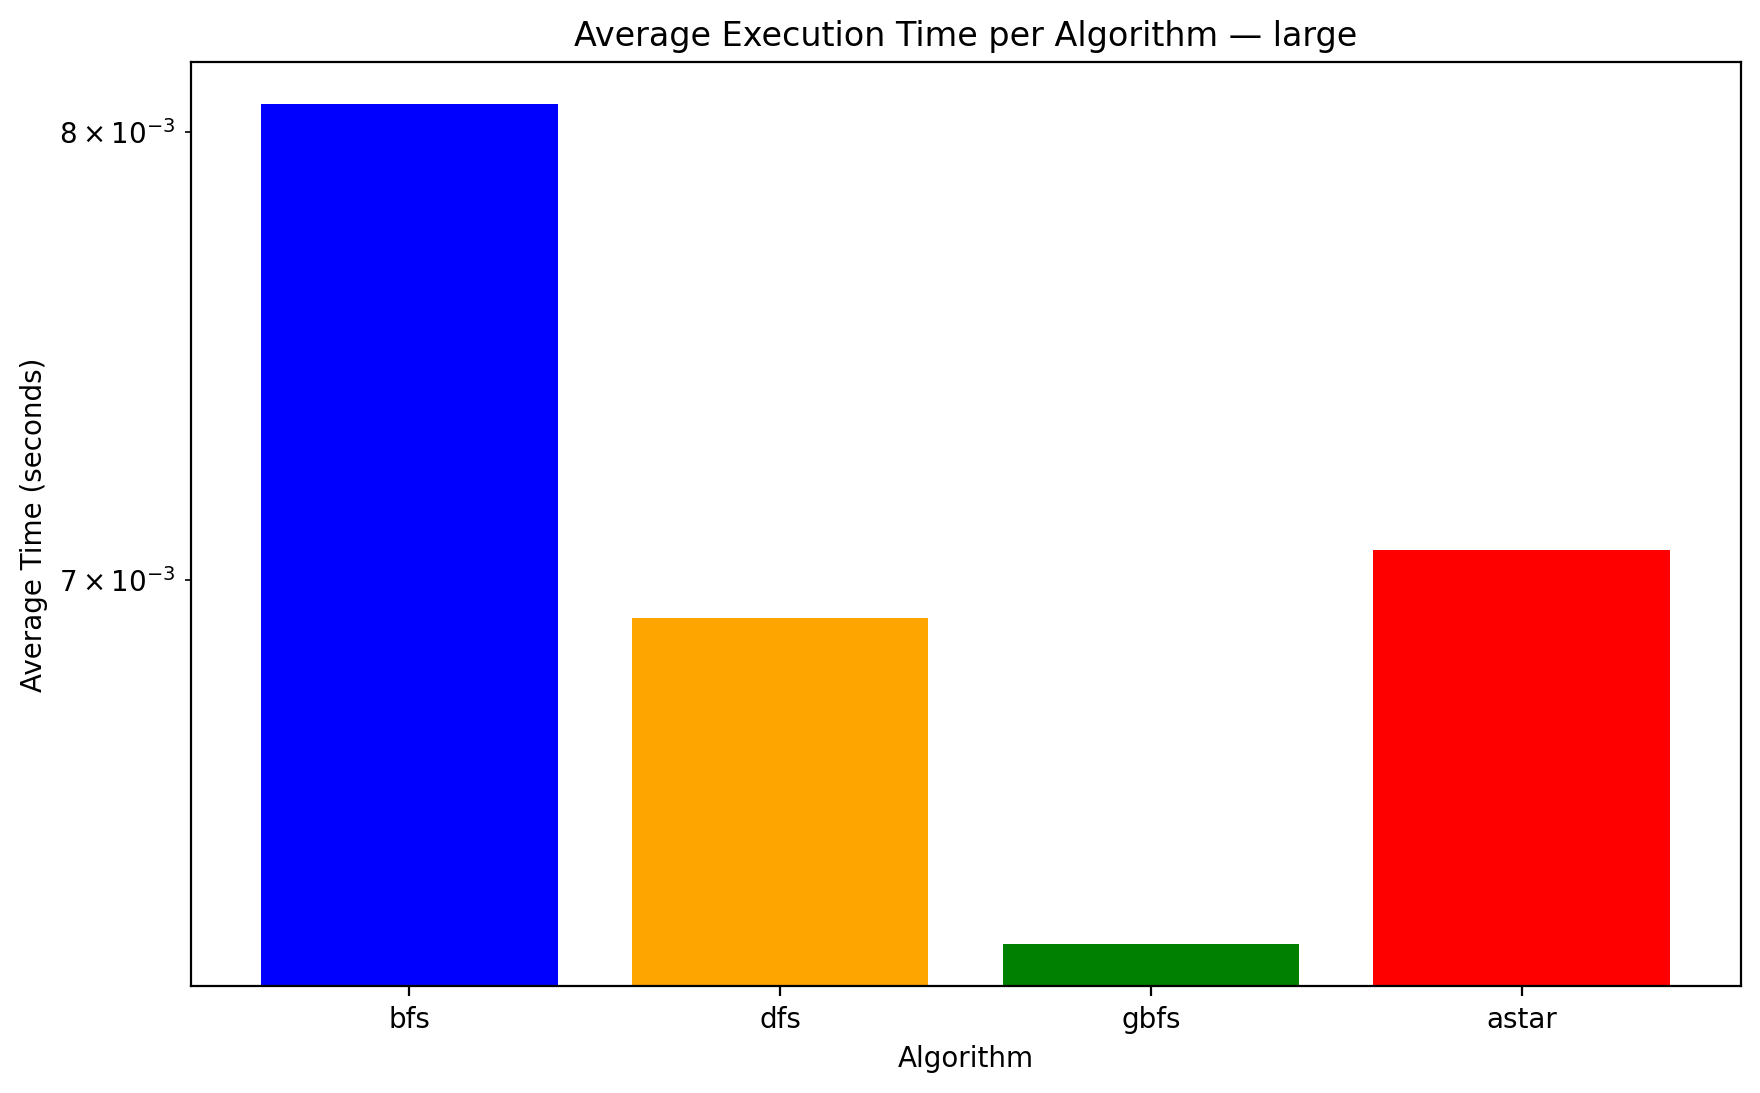

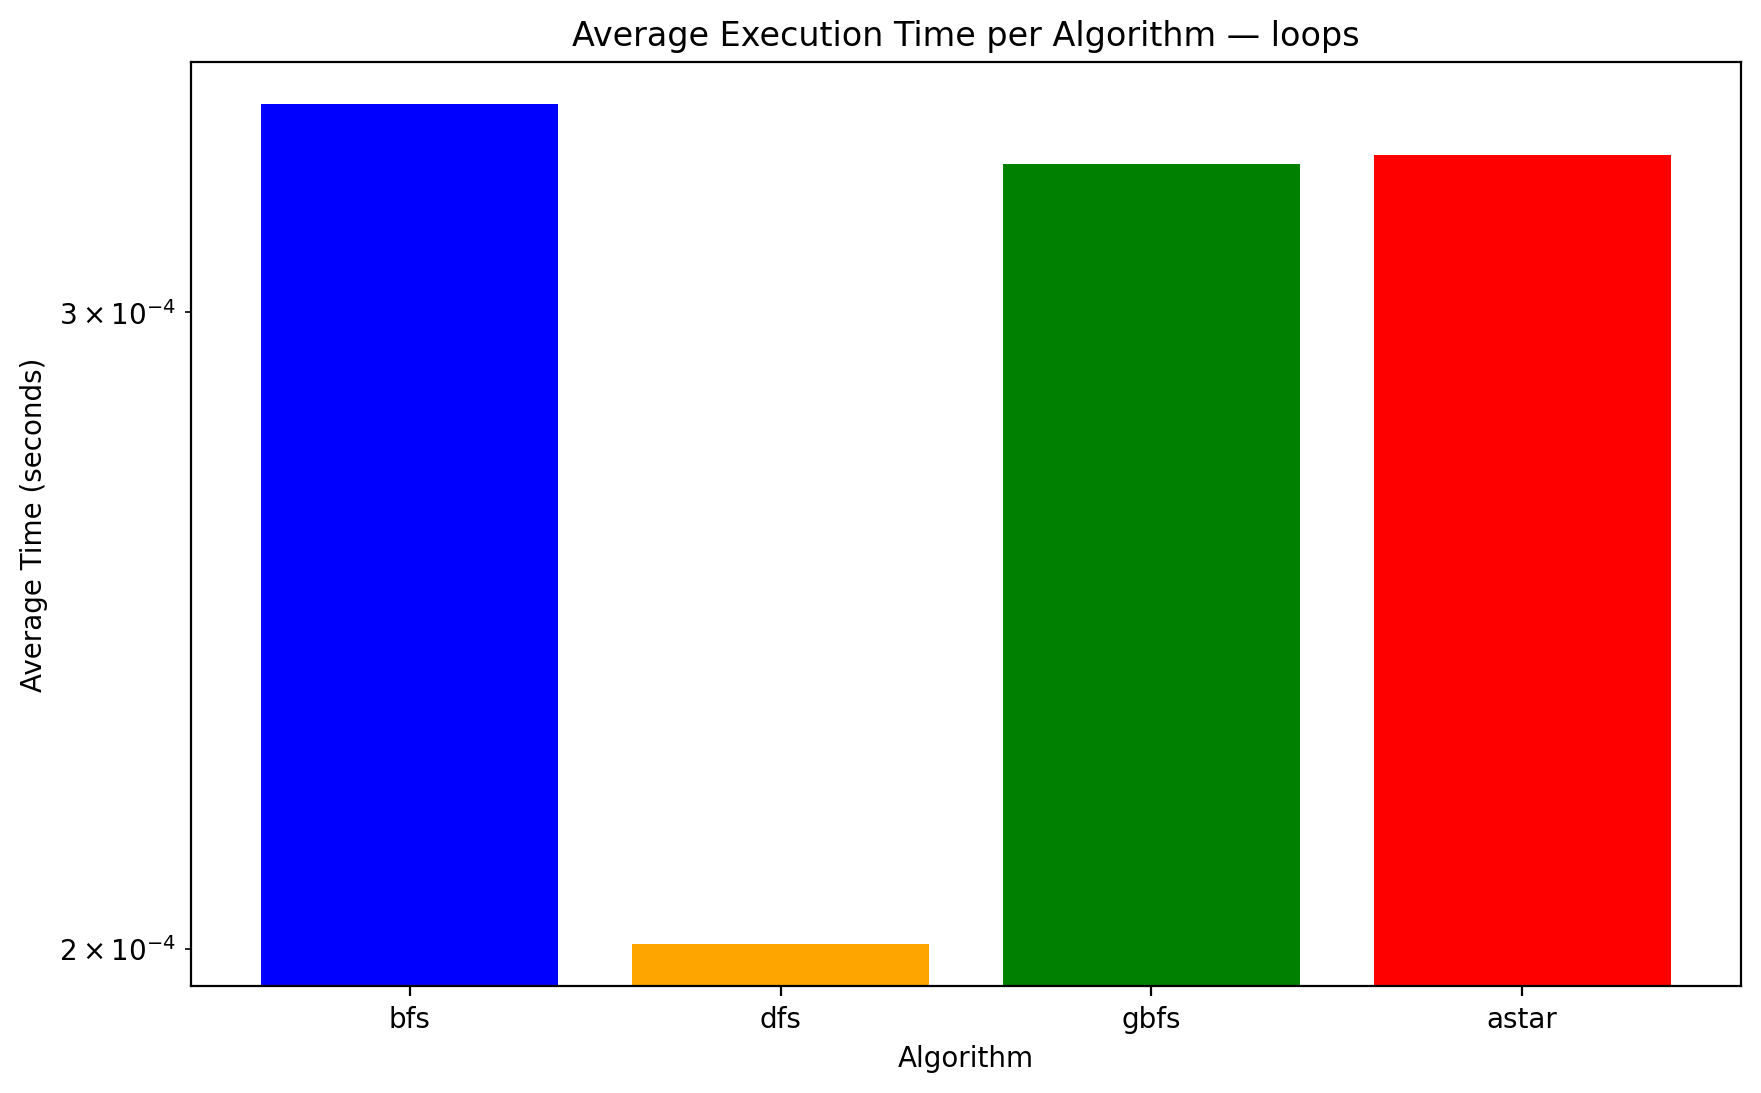

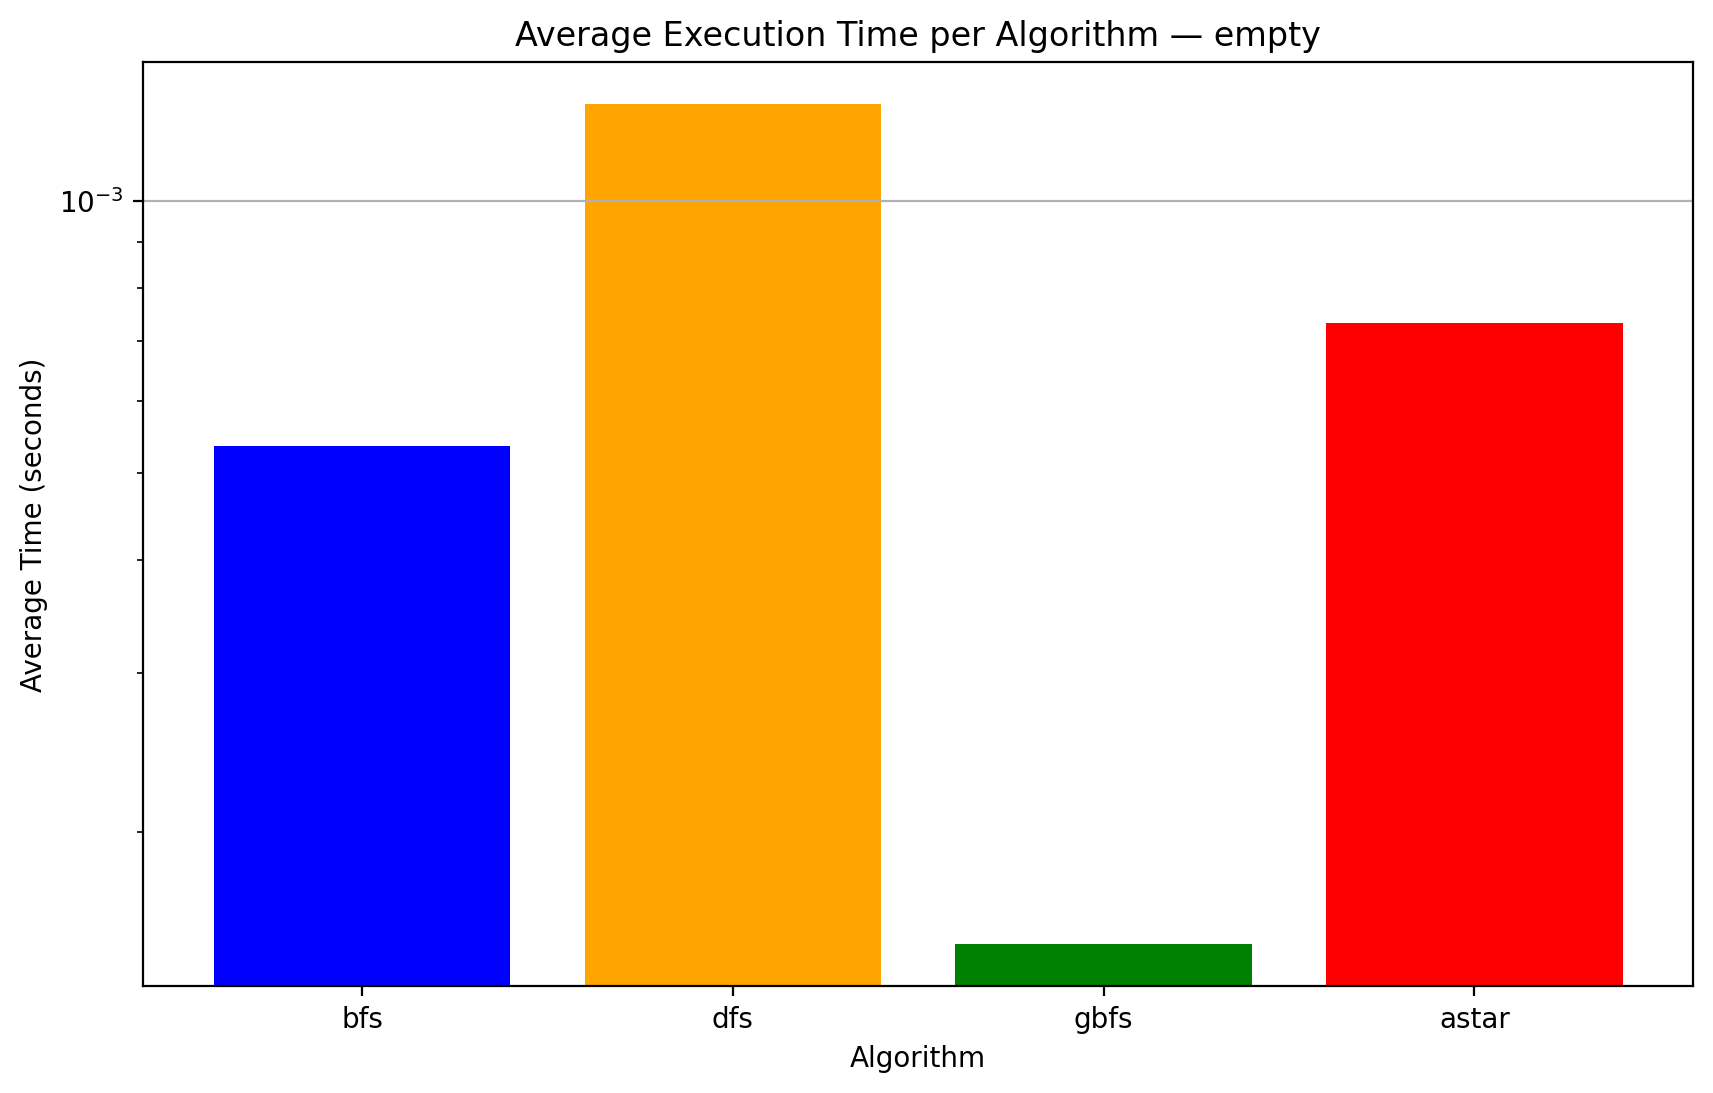

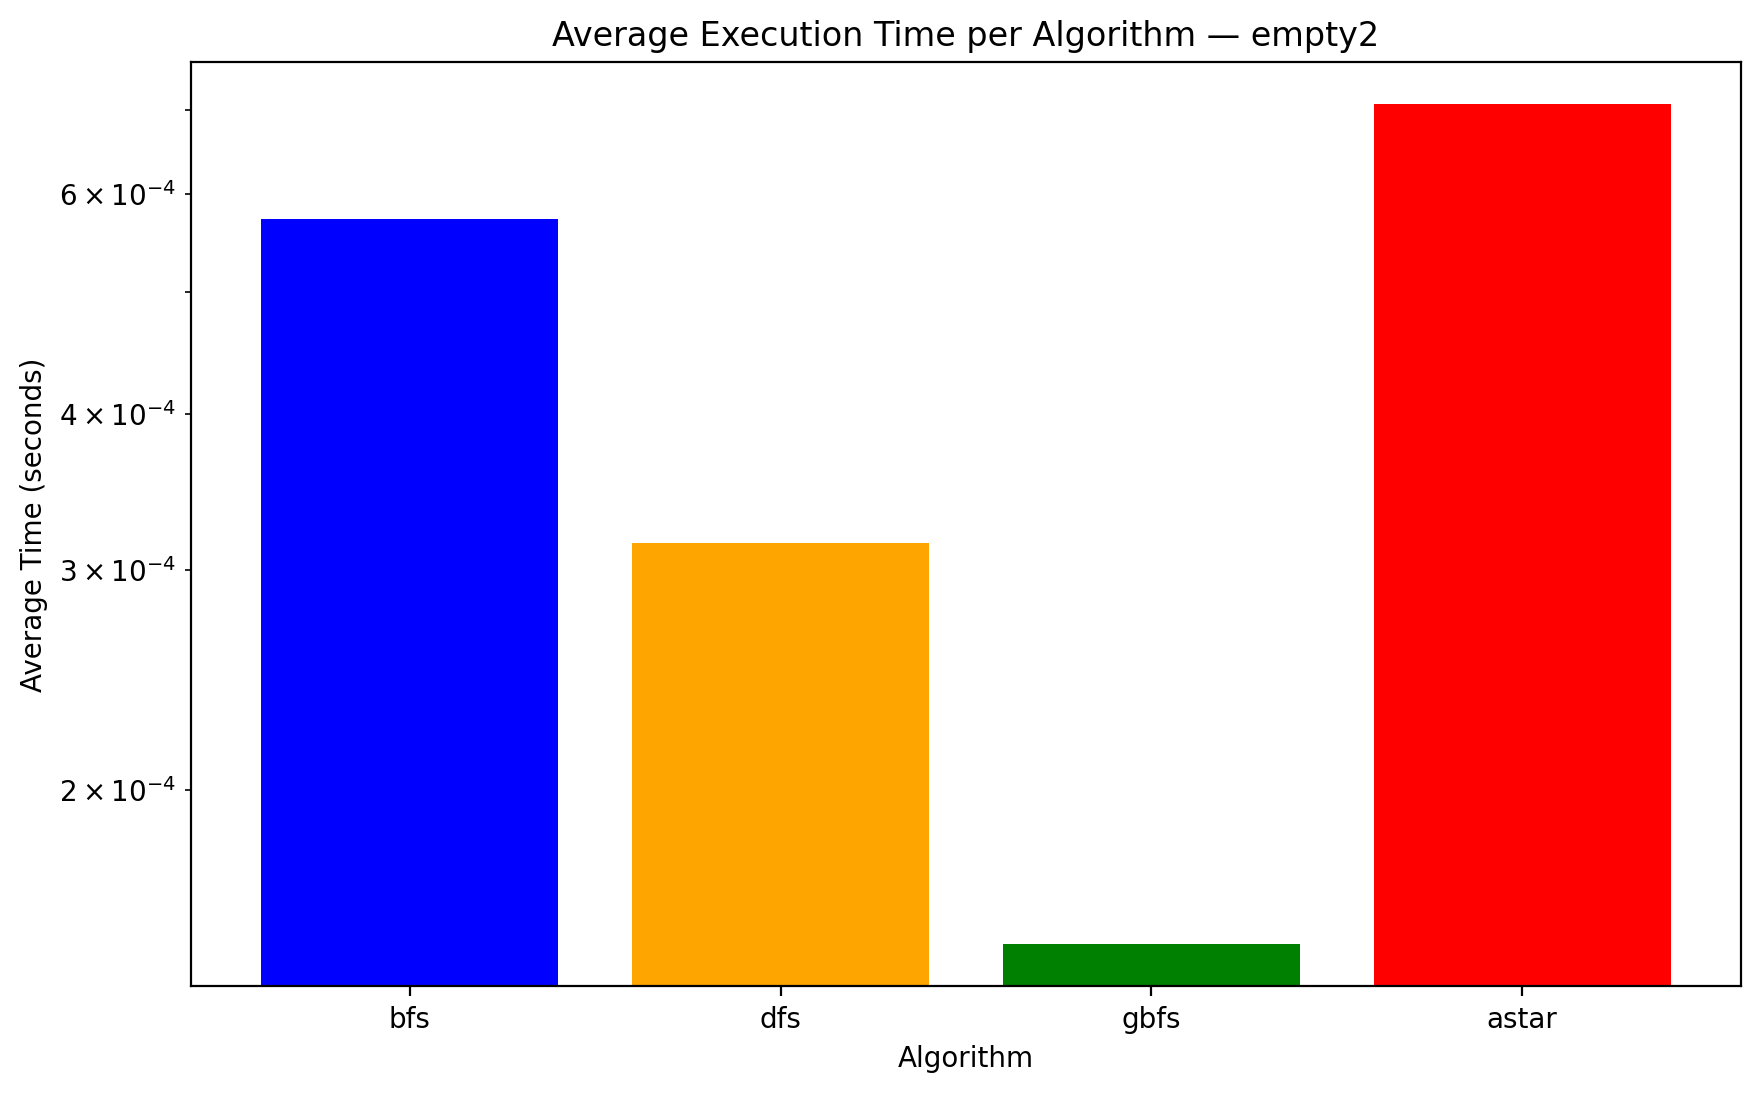

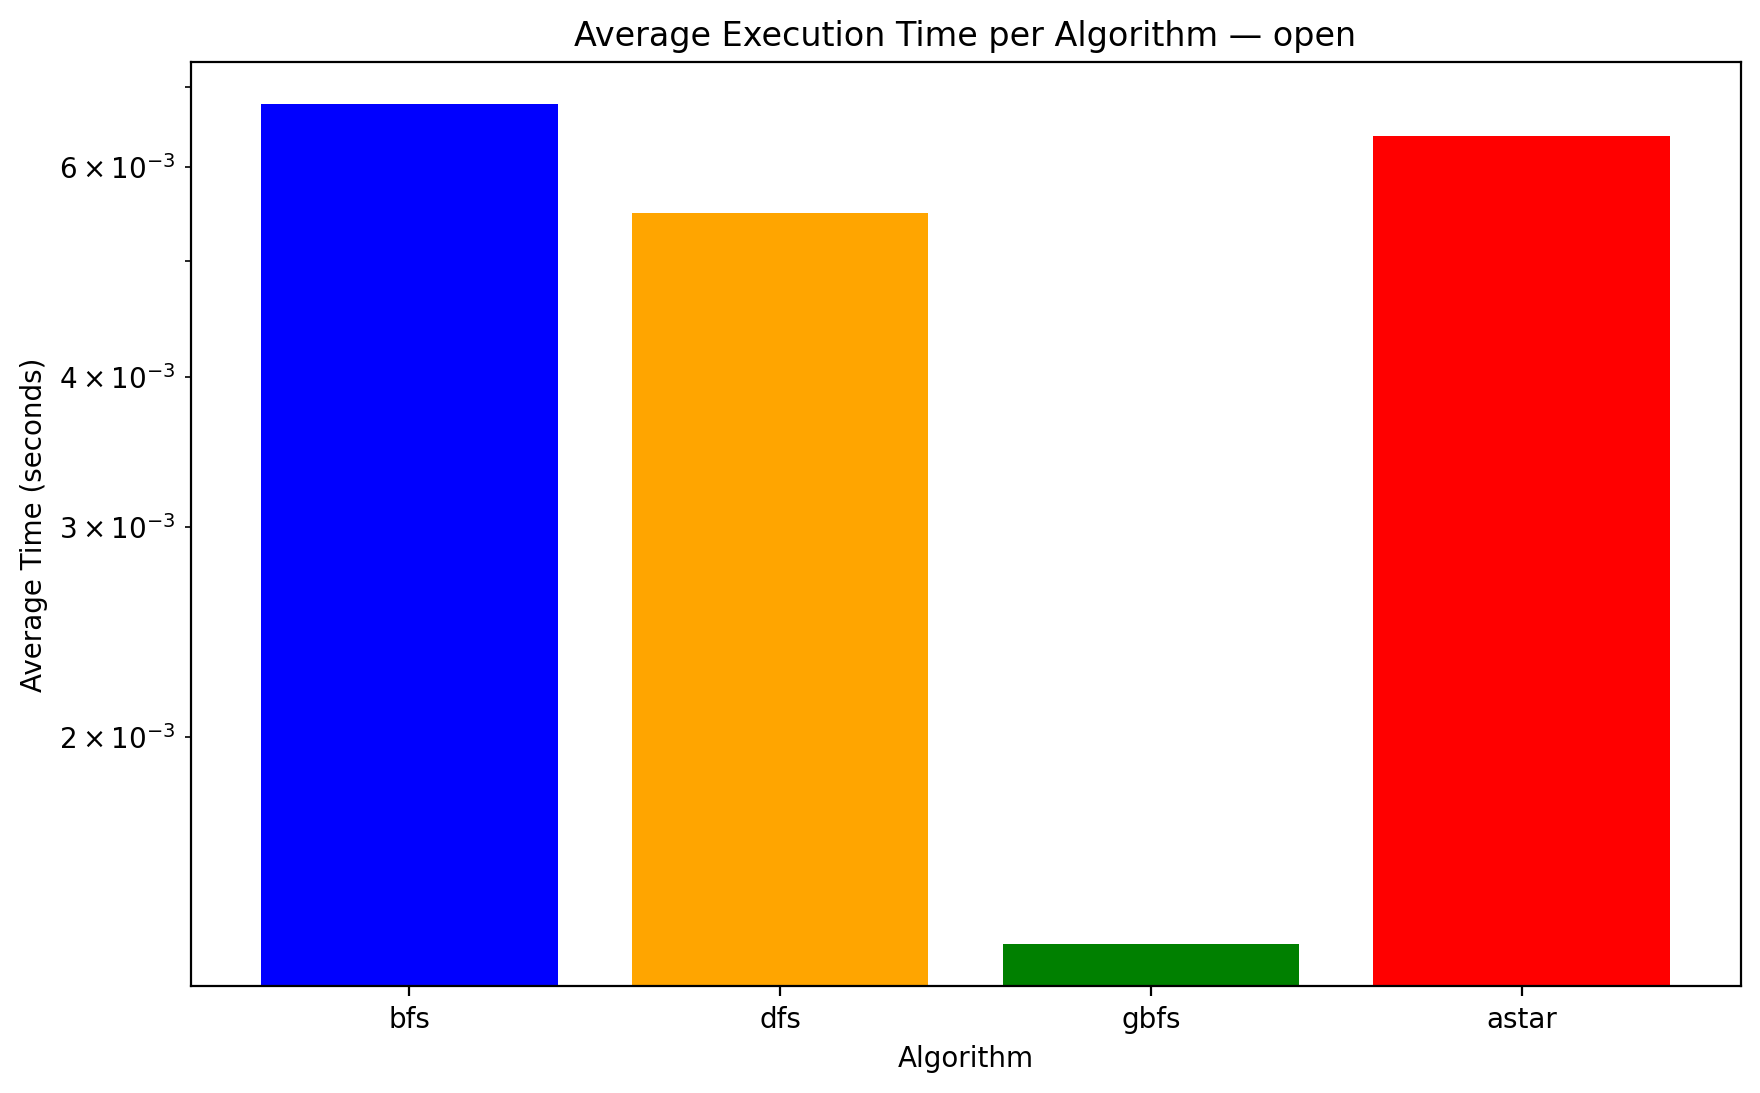

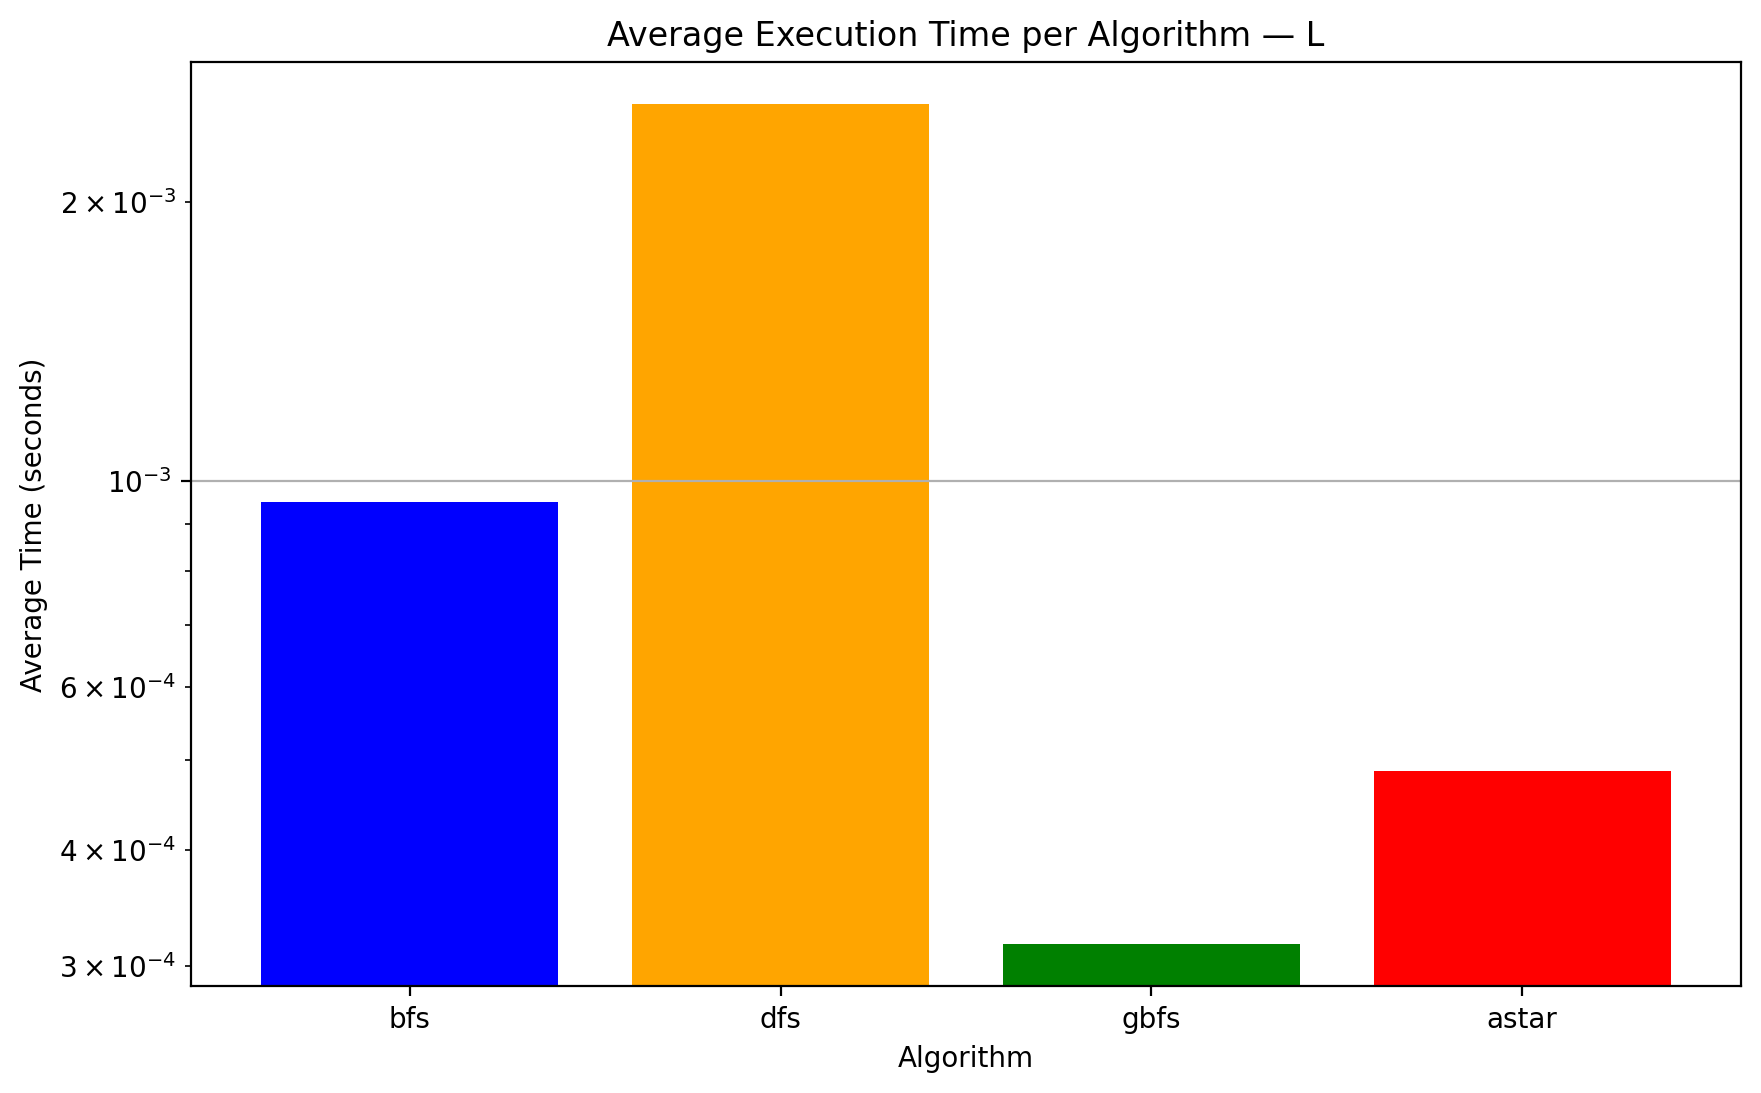

In [179]:
import matplotlib.pyplot as plt
import time

# one bucket per maze key and algorithm
time_results = {maze_key: {alg: [] for alg in algorithms} for maze_key in maze_files}
memory_results = {maze_key: {alg: [] for alg in algorithms} for maze_key in maze_files}
for maze_key, maze_path in maze_files.items():
    with open(maze_path, "r") as f:
        maze_str = f.read()
    maze = mh.parse_maze(maze_str)

    for algorithm in algorithms:
        for i in range(runs):
            start_time = time.time()
            match algorithm:
                case "bfs":
                    path, cost, expanded, depth, frontier, memory, solution = breadth_first_search(maze)
                case "dfs":
                    path, cost, expanded, depth, frontier, memory, solution = depth_first_search(maze)
                case "gbfs":
                    path, cost, expanded, depth, frontier, memory, solution = greedy_best_first_search(maze)
                case "astar":
                    path, cost, expanded, depth, frontier, memory, solution = a_star_search(maze)
            end_time = time.time()
            memory_results[maze_key][algorithm].append(memory)
            time_results[maze_key][algorithm].append(end_time - start_time)

avg_time_results = {
    maze_key: {
        alg: (sum(times) / len(times) if times else float("nan"))
        for alg, times in alg_dict.items()
    }
    for maze_key, alg_dict in time_results.items()
}

for maze_key, alg_avgs in avg_time_results.items():
    plt.figure(figsize=(10, 6))
    plt.bar(alg_avgs.keys(), alg_avgs.values(), color=['blue','orange','green','red'])
    plt.xlabel('Algorithm')
    plt.ylabel('Average Time (seconds)')
    plt.title(f'Average Execution Time per Algorithm — {maze_key}')
    plt.yscale('log')
    plt.grid(axis='y')
    plt.show()



   

As we can see, it pays to be greedy in most cases. In all except the loops maze, GBFS performed the quickest. However, we can see that optimality also takes time, as BFS and A* both performed the worst in most cases due to them having to traverse more area on the maze than DFS or GBFS

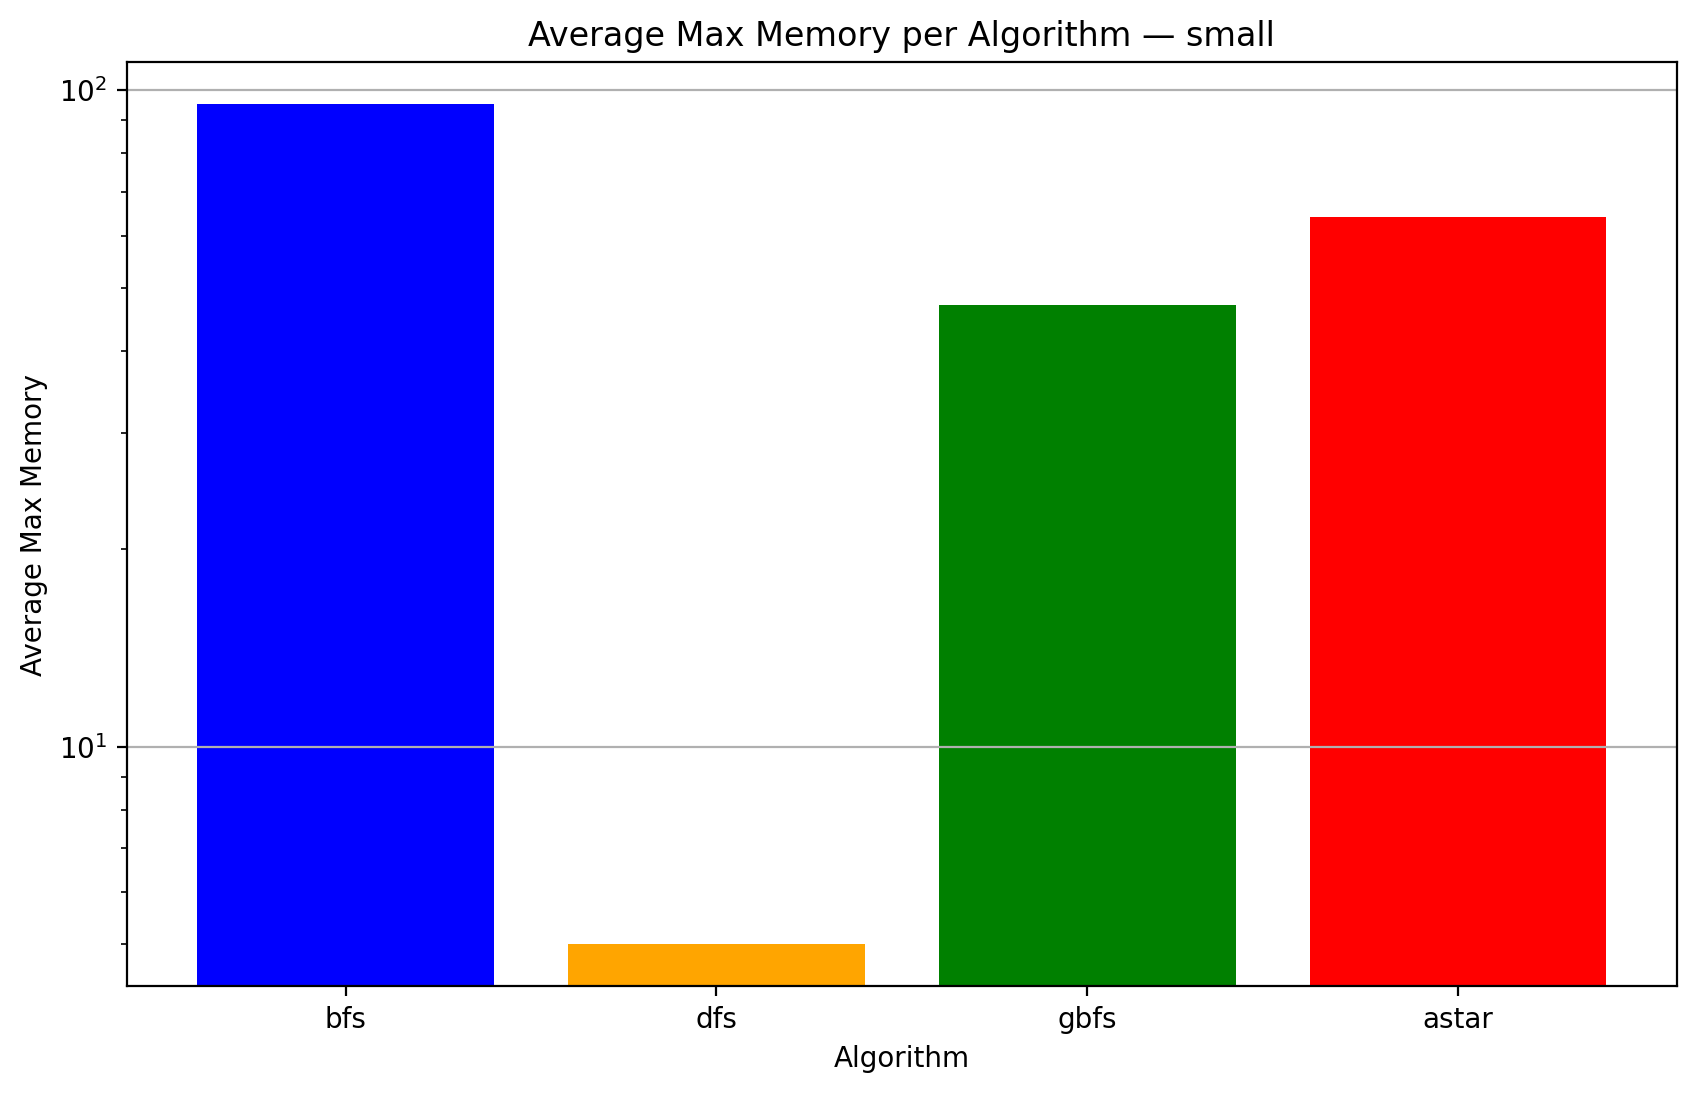

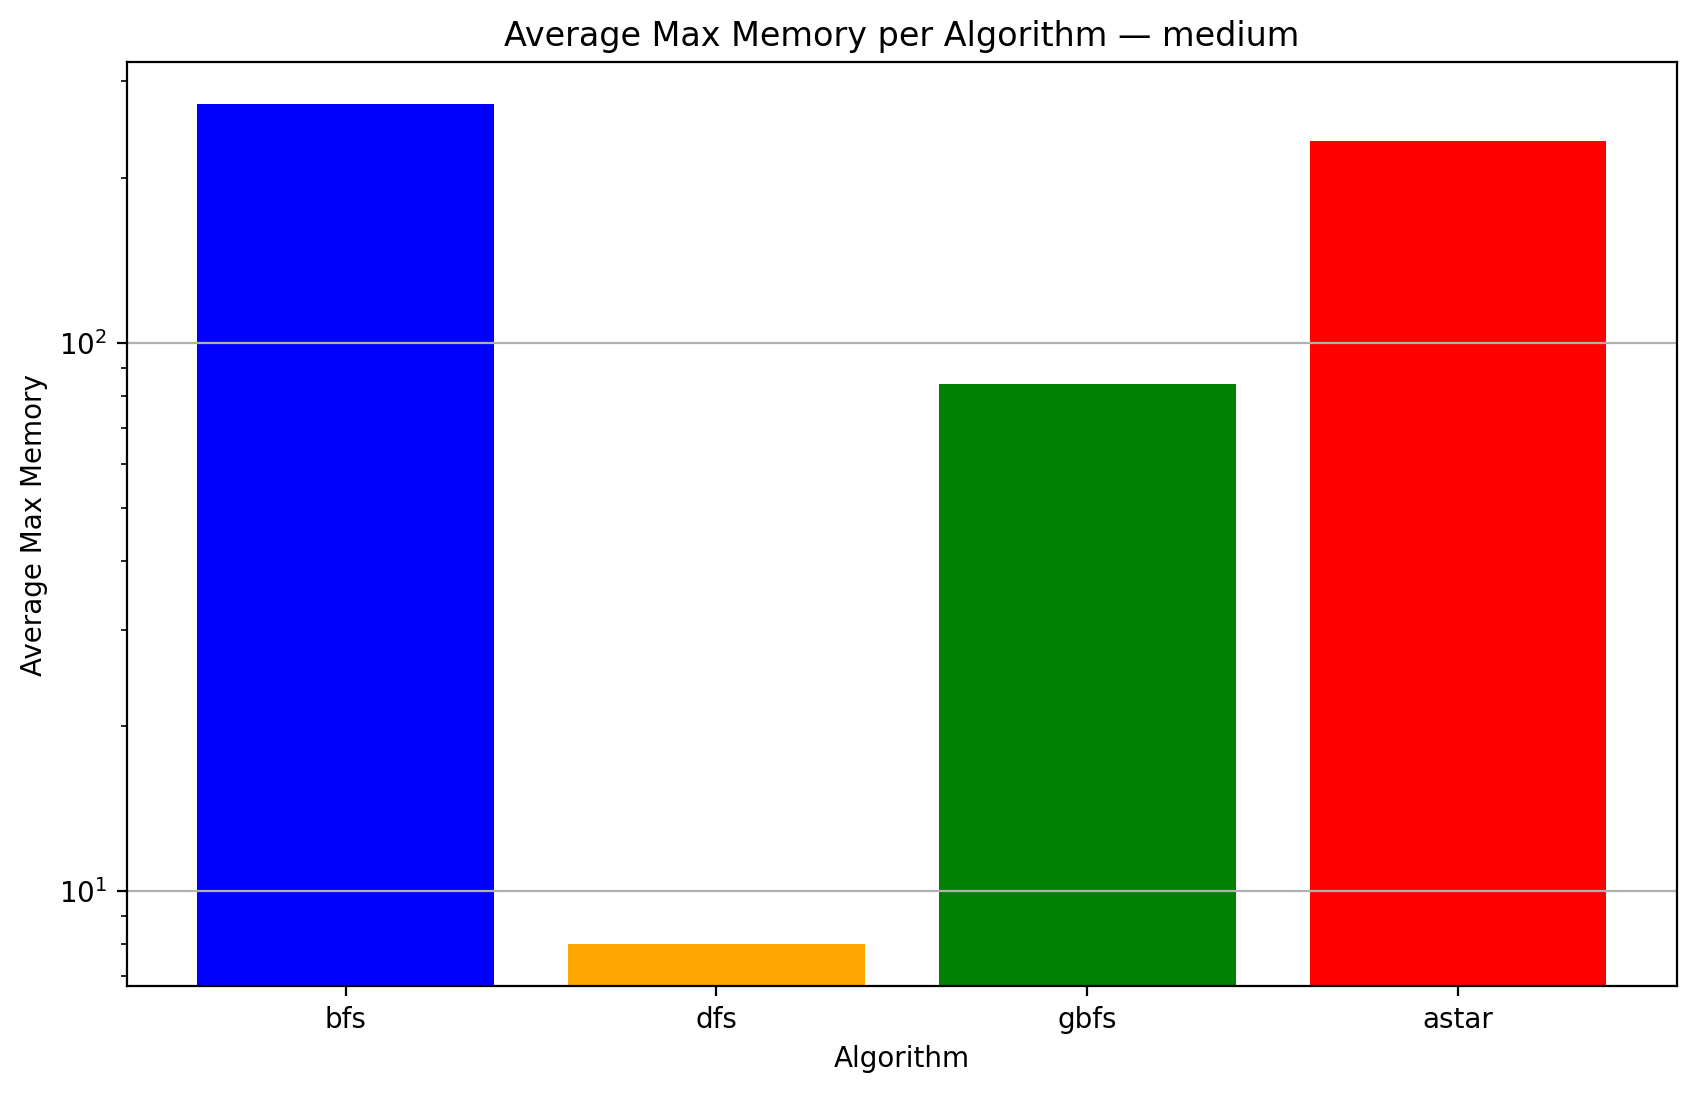

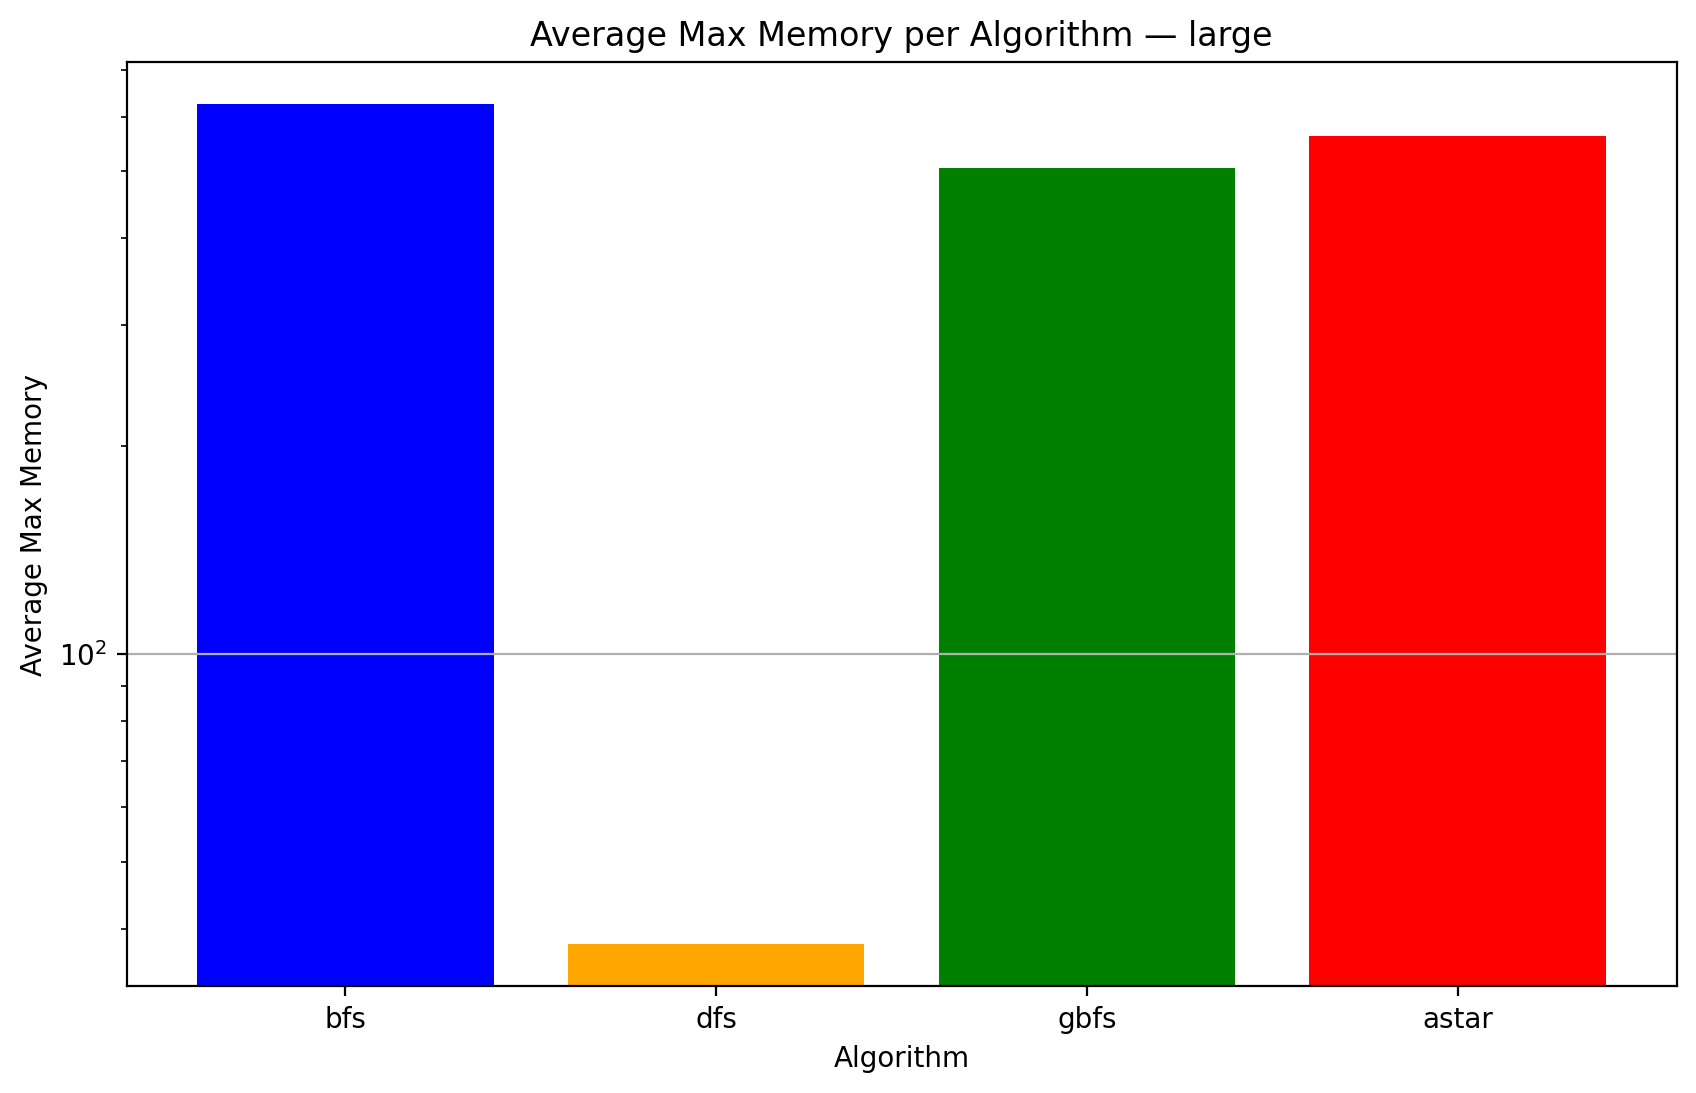

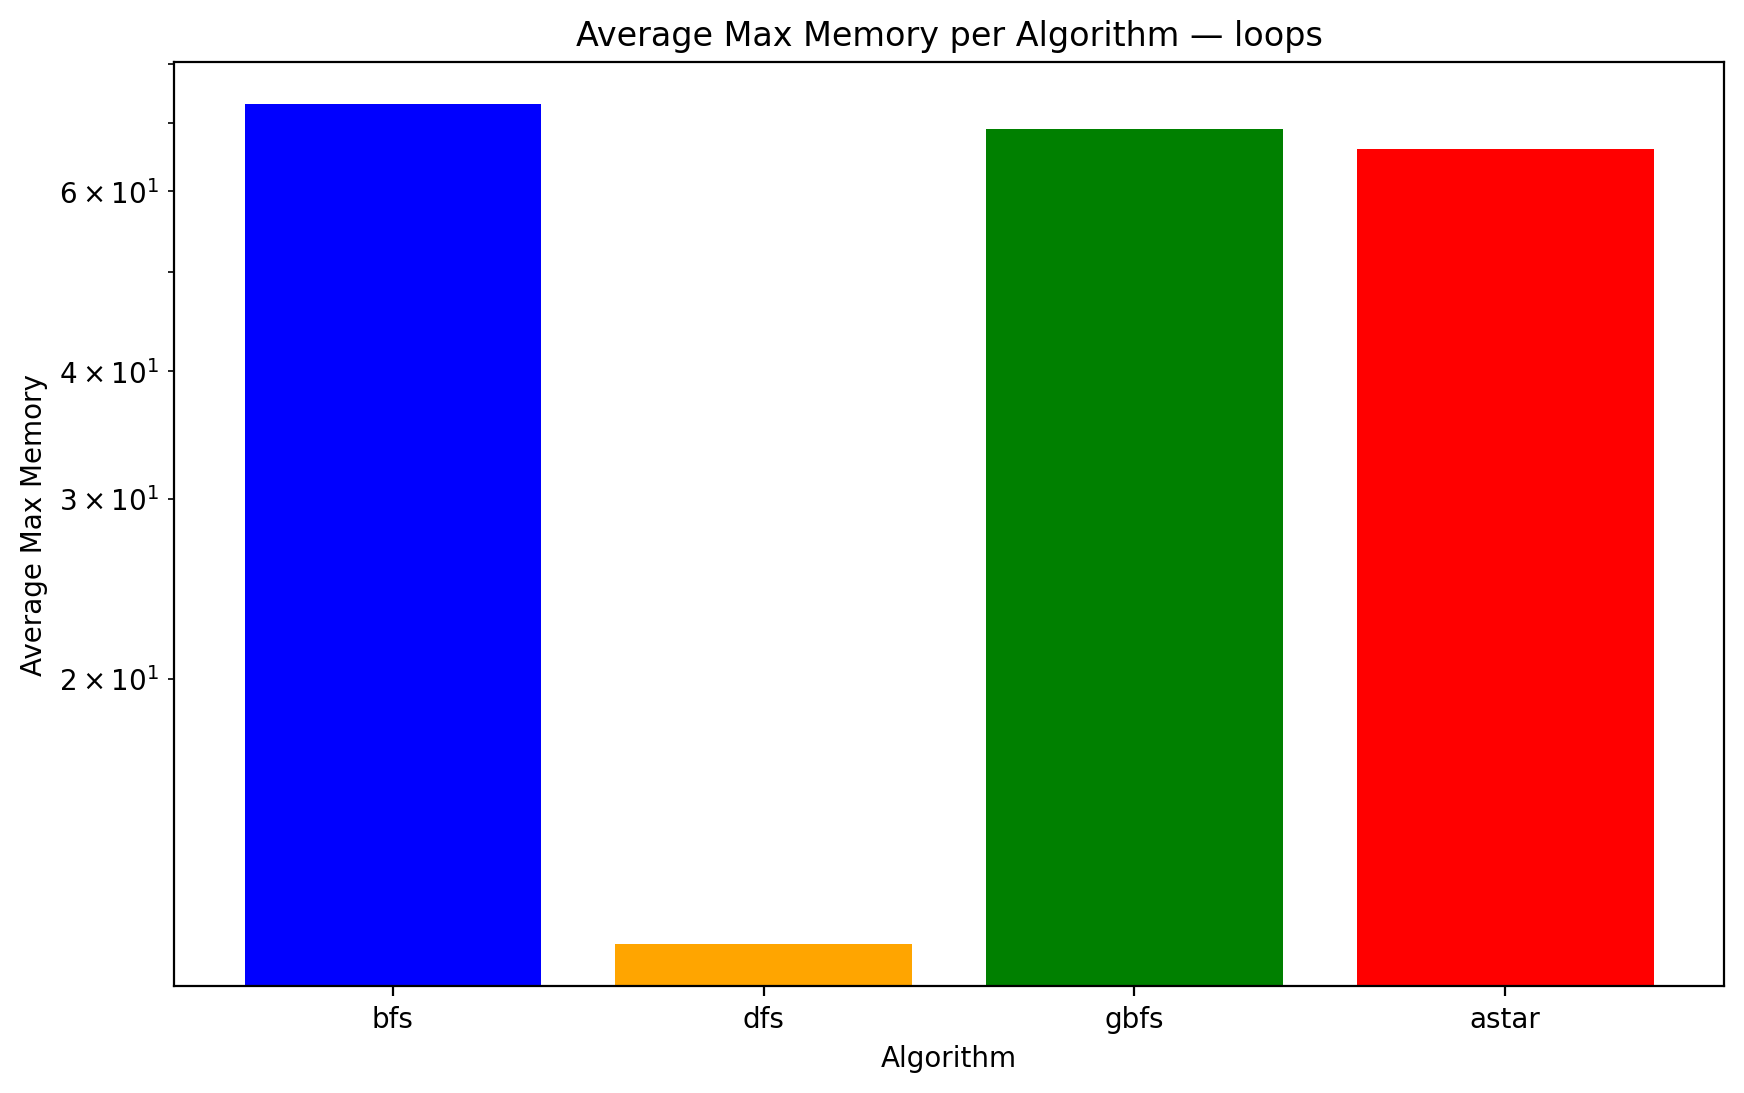

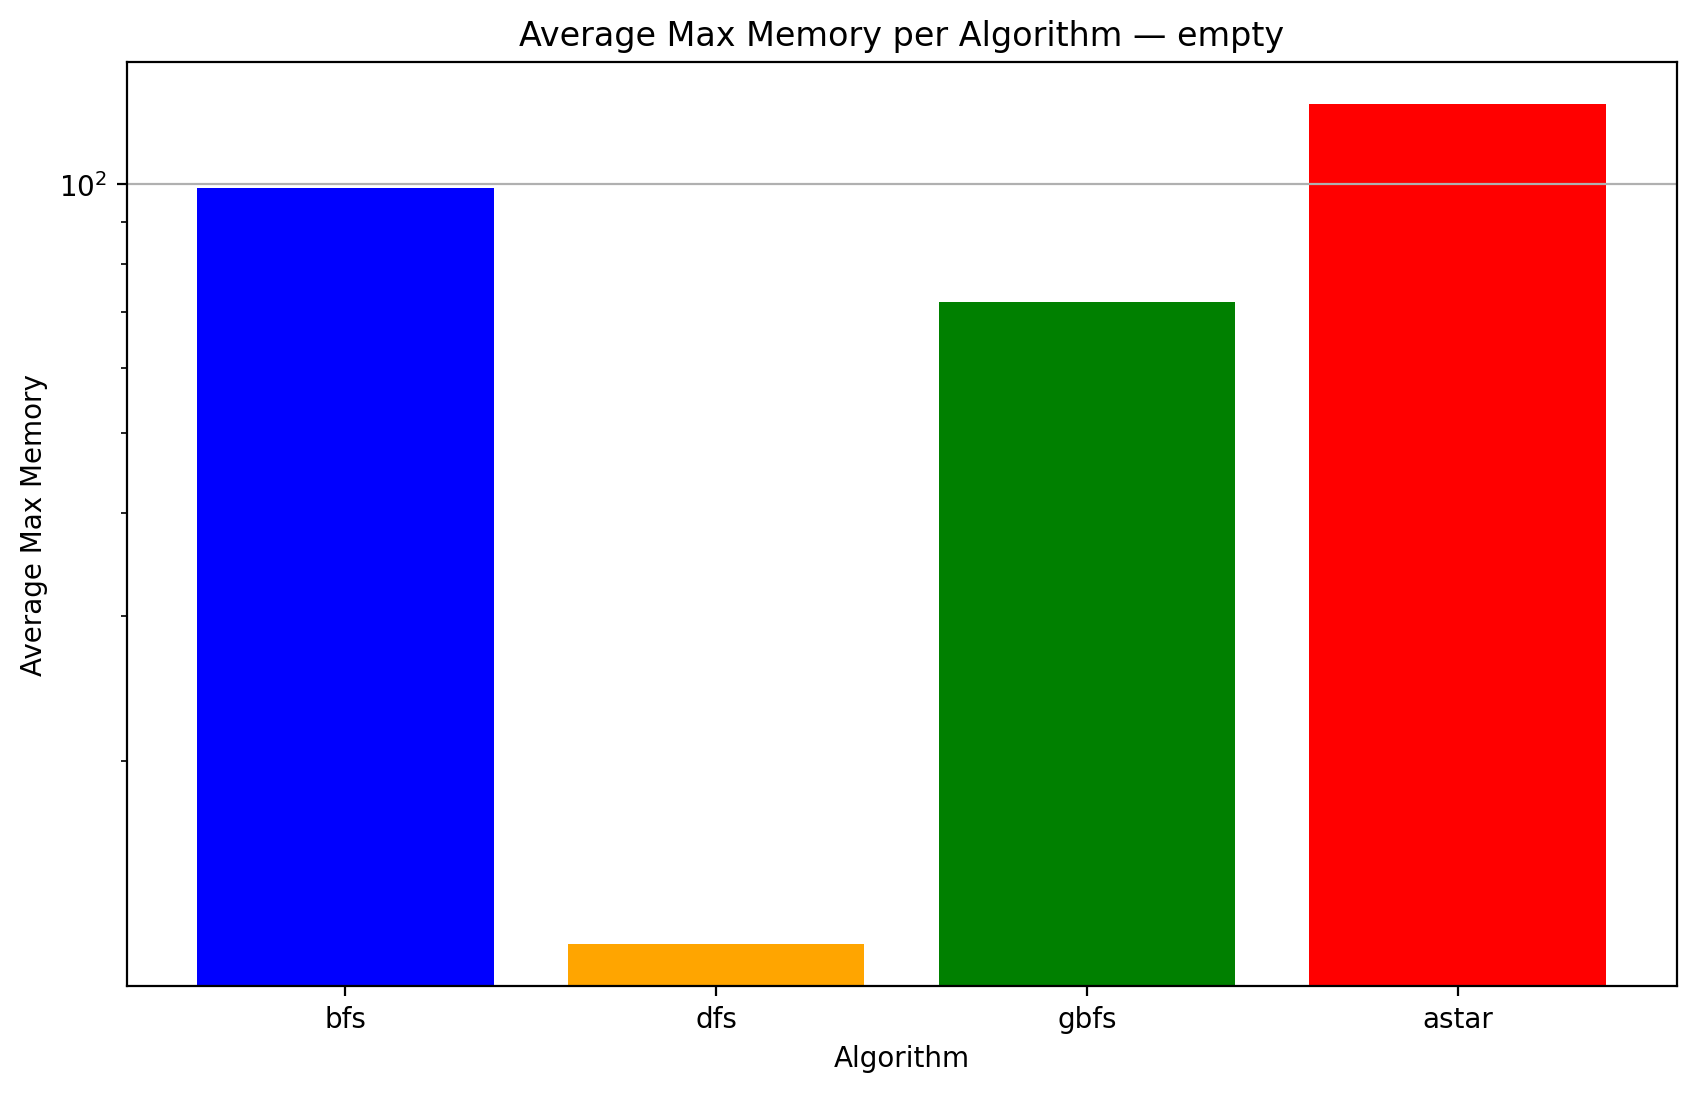

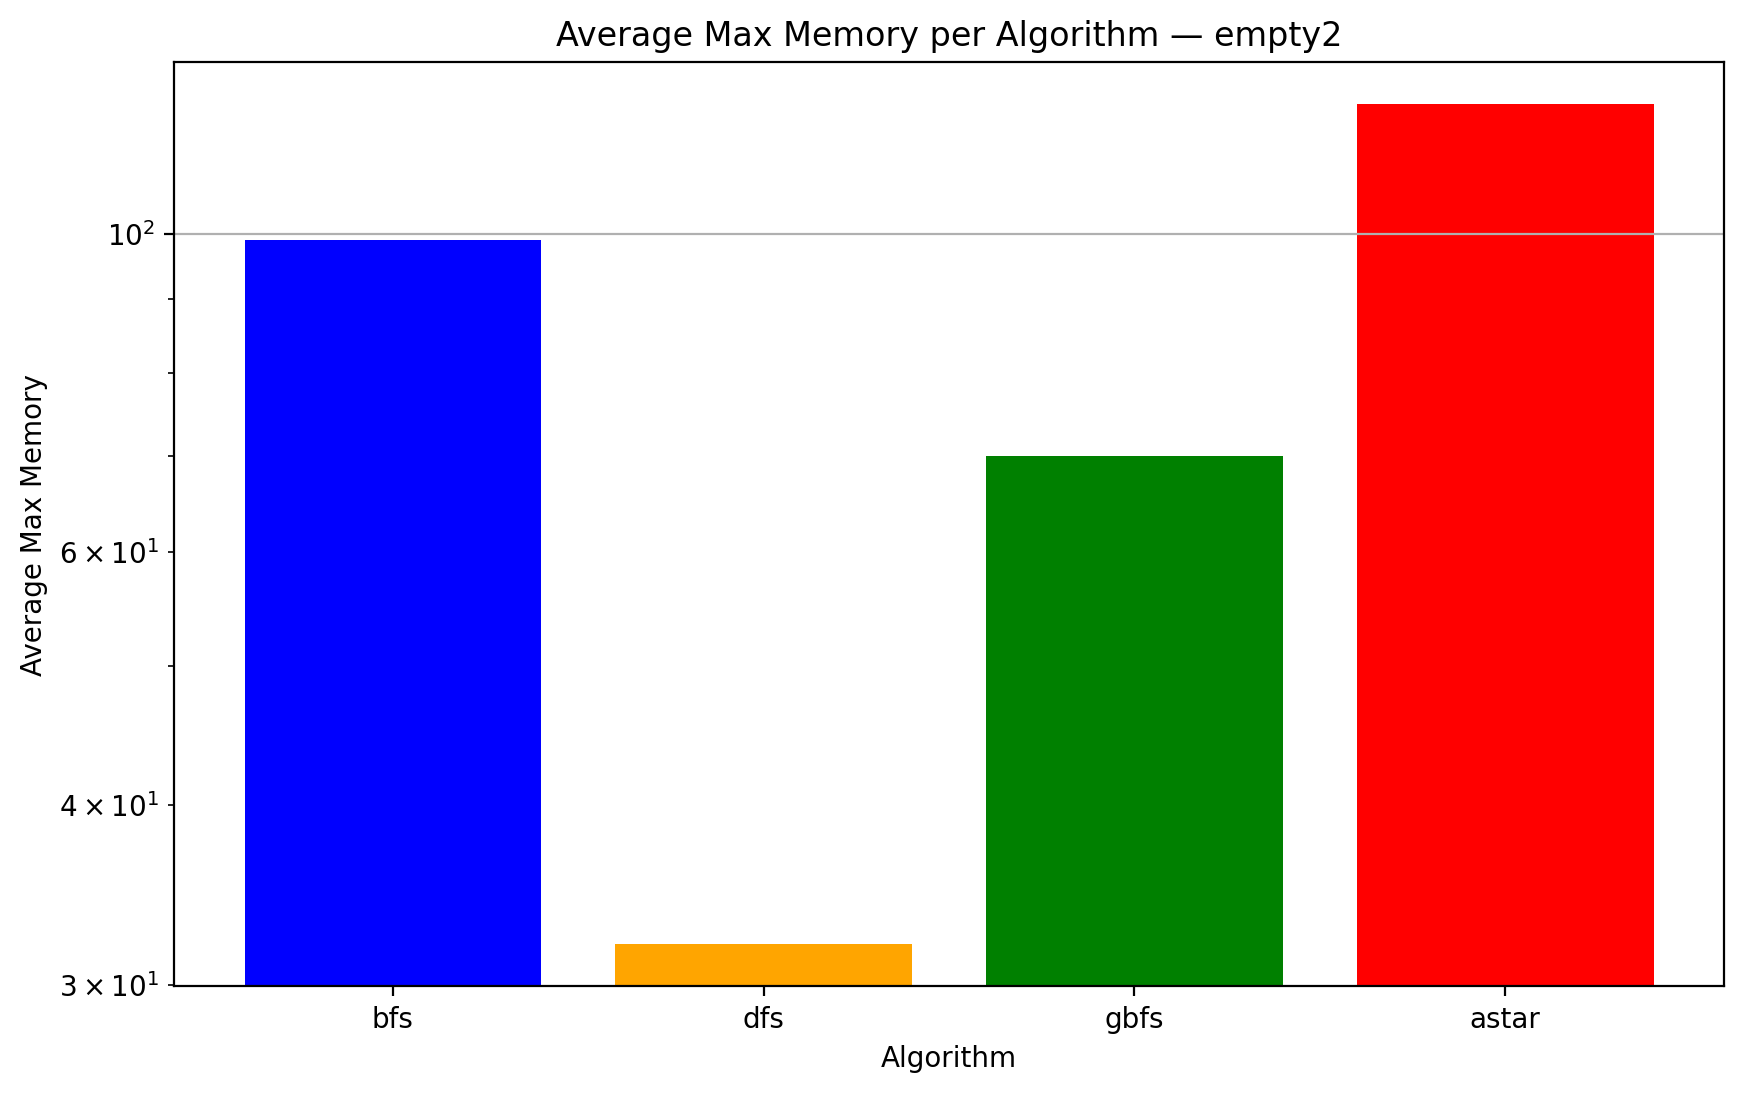

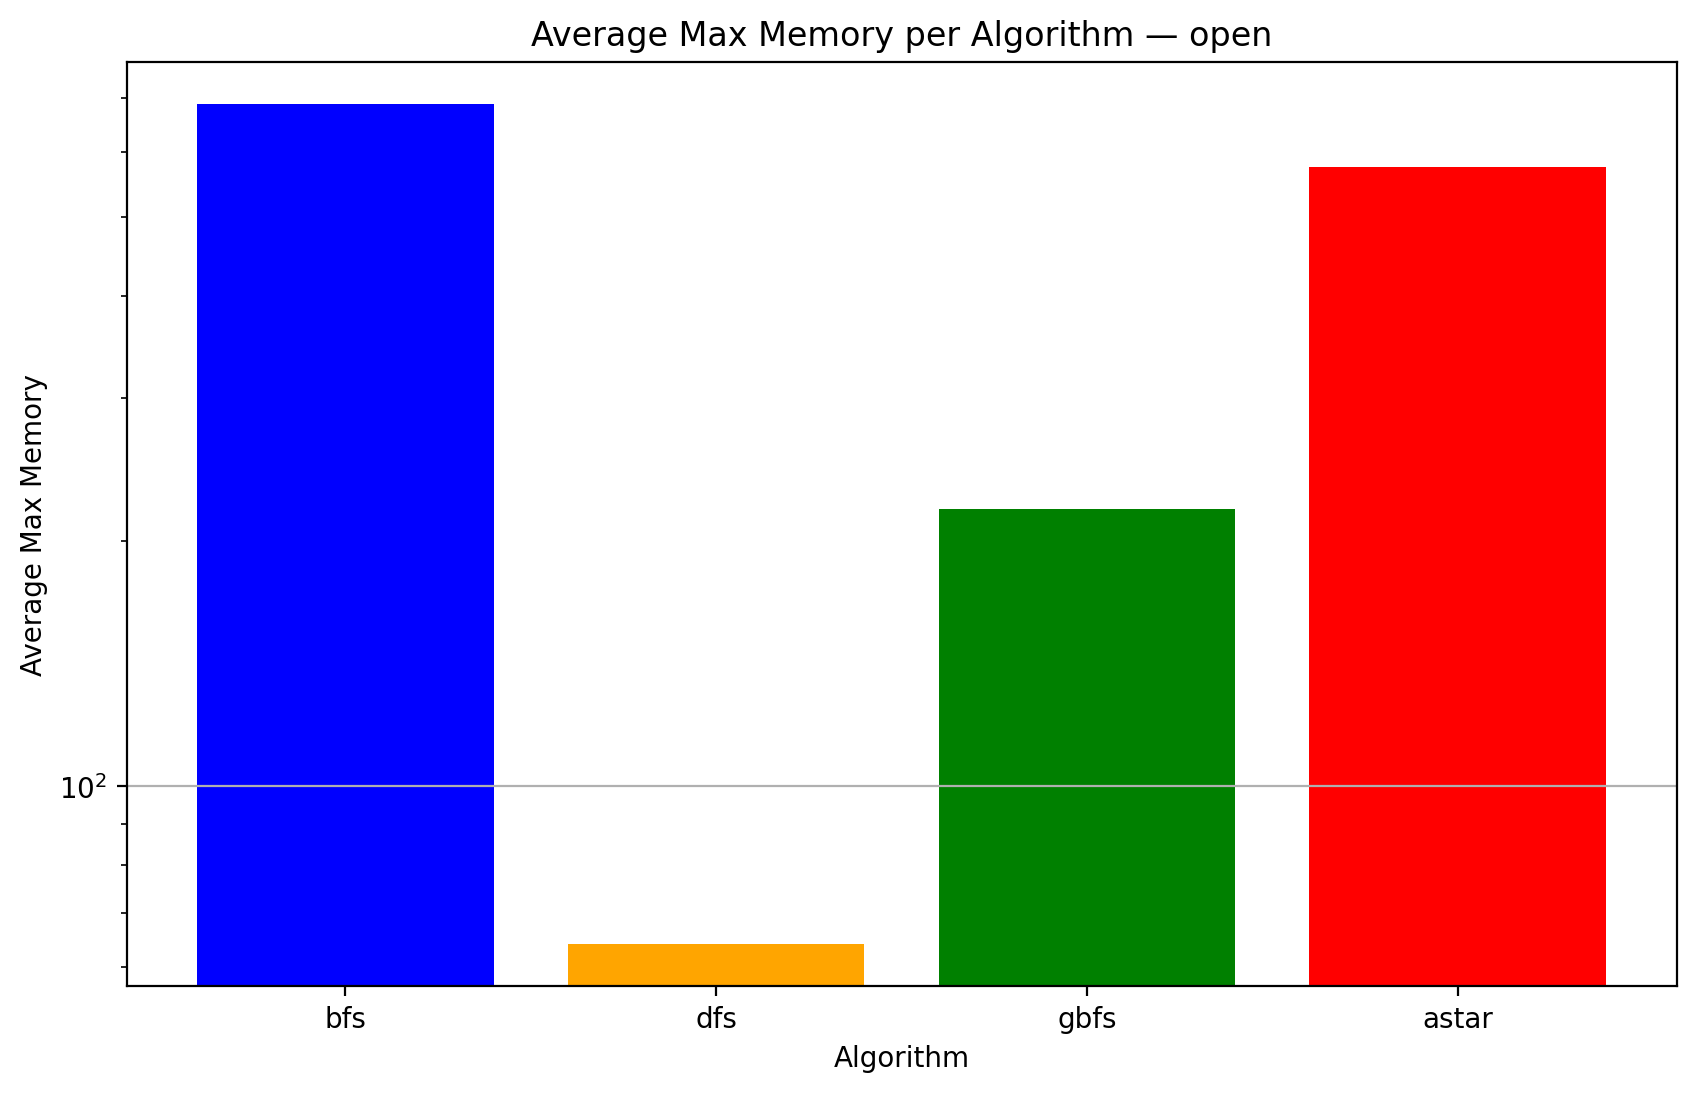

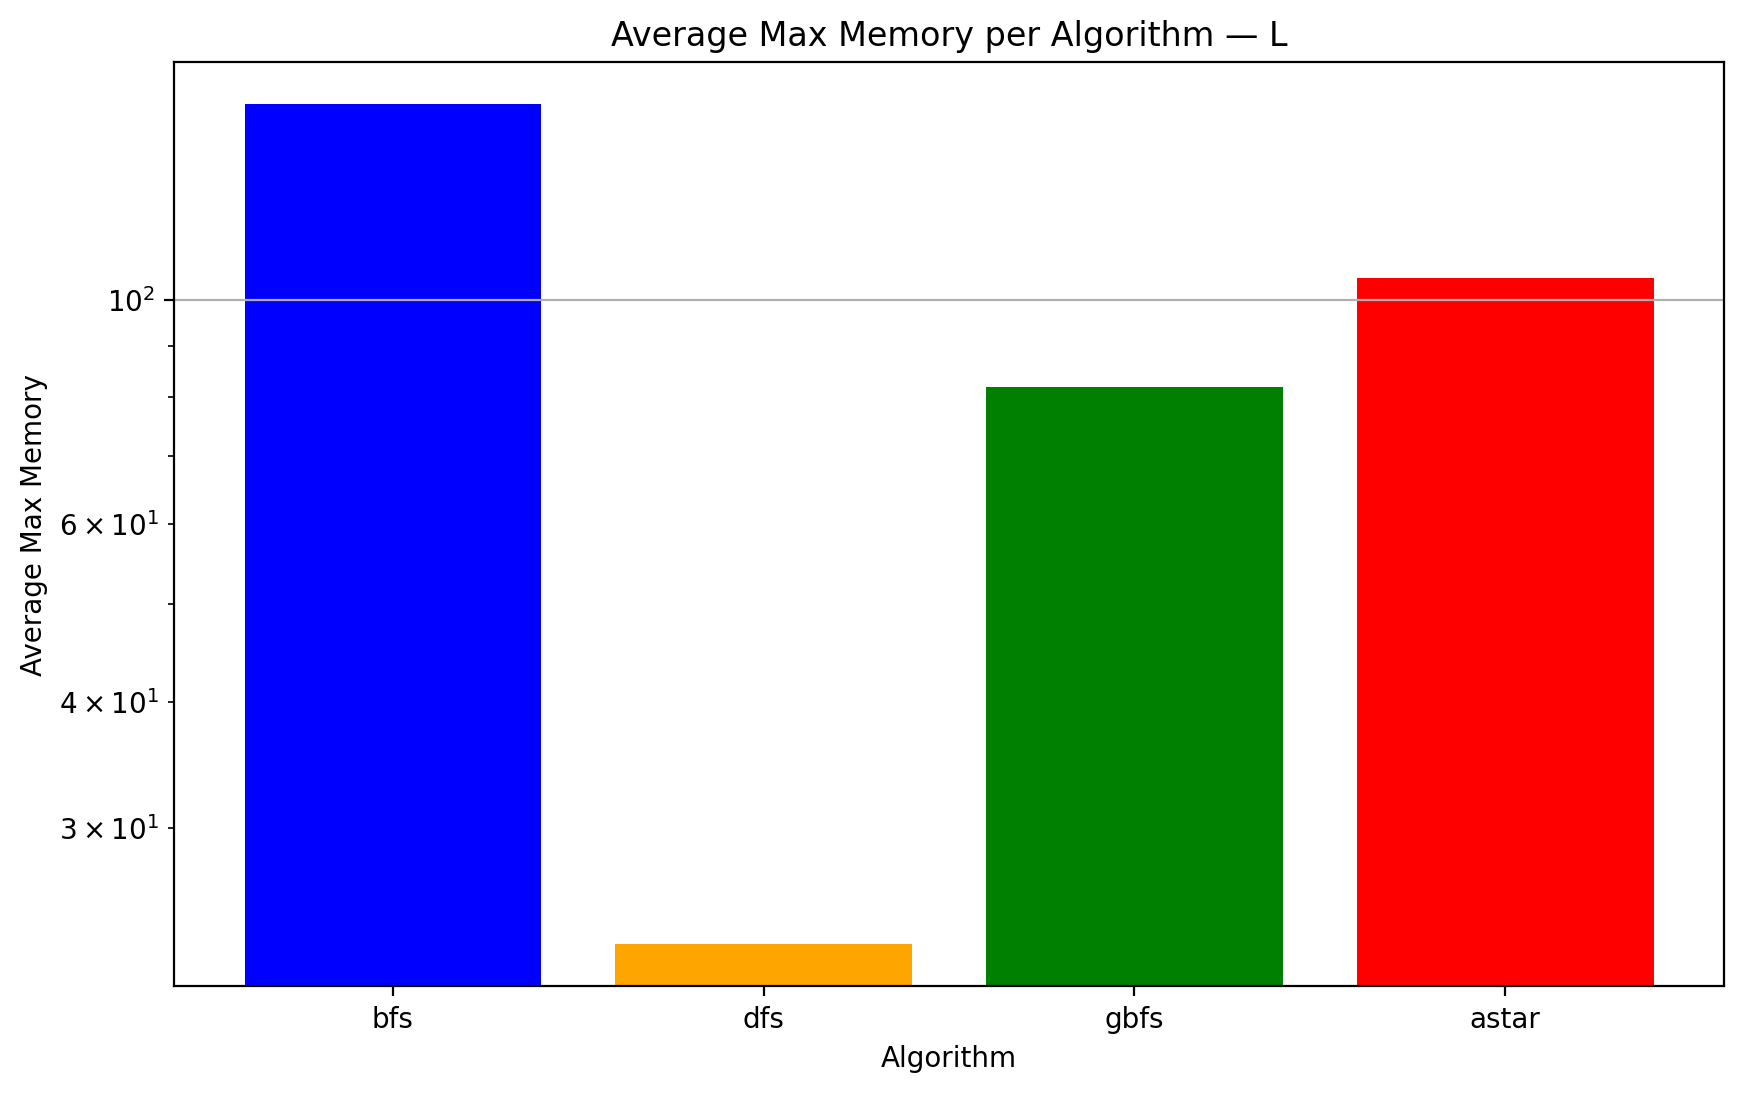

In [180]:
avg_memory_results = {
    maze_key: {
        alg: (sum(times) / len(times) if times else float("nan"))
        for alg, times in alg_dict.items()
    }
    for maze_key, alg_dict in memory_results.items()
}

for maze_key, alg_avgs in avg_memory_results.items():
    plt.figure(figsize=(10, 6))
    plt.bar(alg_avgs.keys(), alg_avgs.values(), color=['blue','orange','green','red'])
    plt.xlabel('Algorithm')
    plt.ylabel('Average Max Memory')
    plt.title(f'Average Max Memory per Algorithm — {maze_key}')
    plt.yscale('log')
    plt.grid(axis='y')
    plt.show()

While DFS will largely be slower, it will certainly be more memory efficient. This is shown in these graphs, where it has by far the smallest memory footprint among the 4 algorithms. This can be explaned by its O(bm) space complexity. Furthermore, we can see how heuristics can inform AStar vs BFS advantage, in most cases AStar will be more memory efficient than BFS, but if the heuristic leads it the wrong way, it can be detrimental to the memory footprint and to the efficiency of the algorithm

Discuss the most important lessons you have learned from implementing the different search strategies.

I learned a few lessons from implementing these 4 strategies:
- It is much harder to get 'optimal' solutions out of algorithms than it is in the books, as there are likely many limiations in the real world that may hinder that, for example the restriction of no visited on DFS, which made the logic harder for larger mazes.
- while an algorithm may be way faster than others, it is easy to see why slower algorithms like DFS still have use today because of their smaller memory footprint. A lot of the memory management/ proceessor management is not empasized in a lot of CS projects, but it is important for real life with real constraints like ones that are seen in this project. 


# All Algorithms Output On All Mazes

Completed bfs on small maze


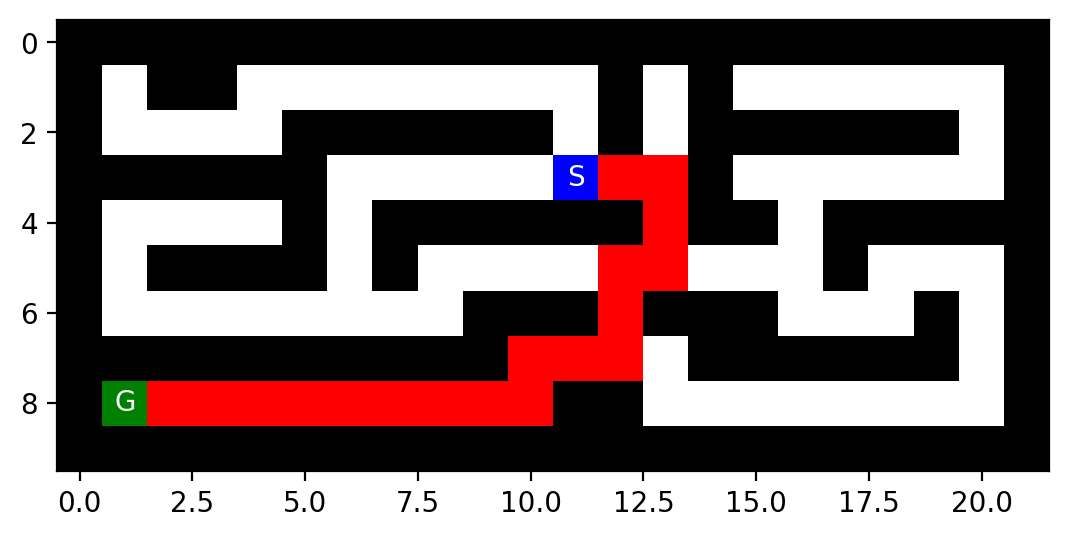

Completed dfs on small maze


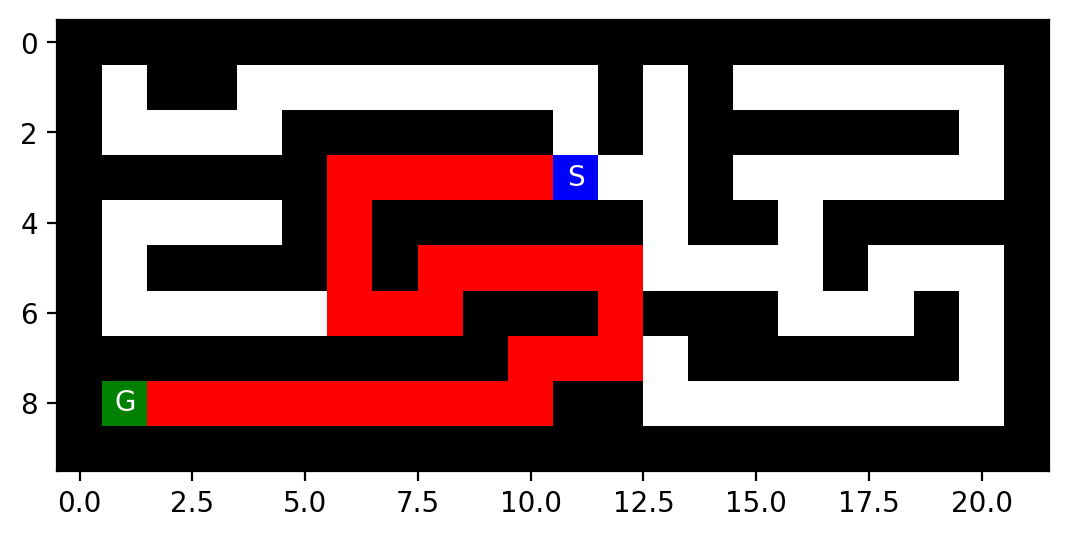

Completed gbfs on small maze


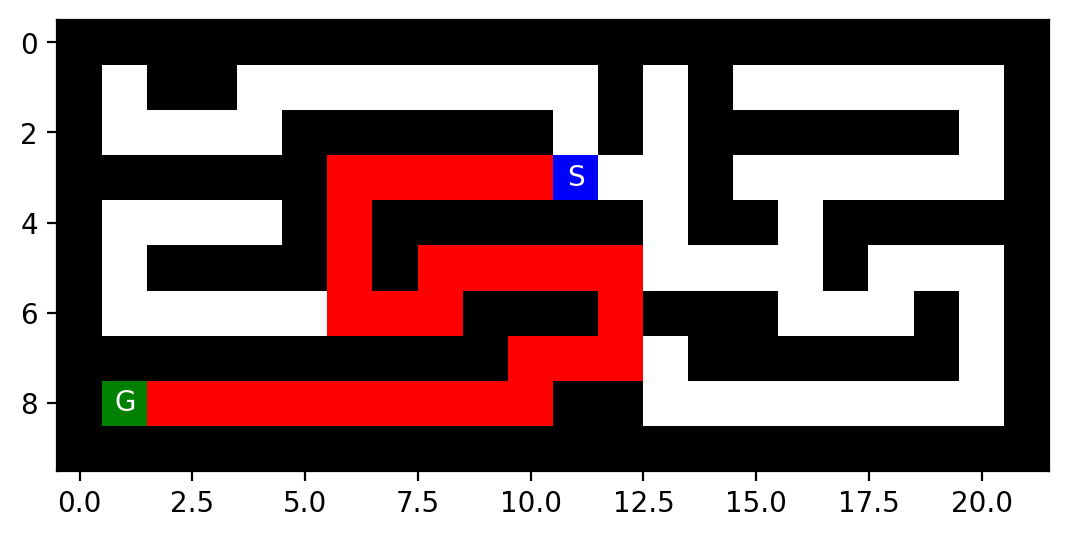

Completed astar on small maze


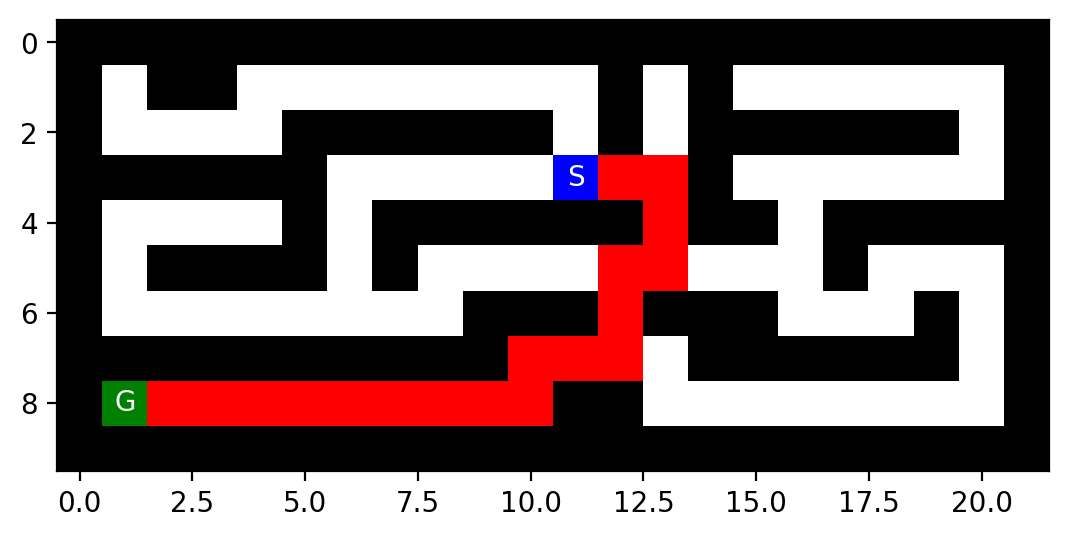

Completed bfs on medium maze


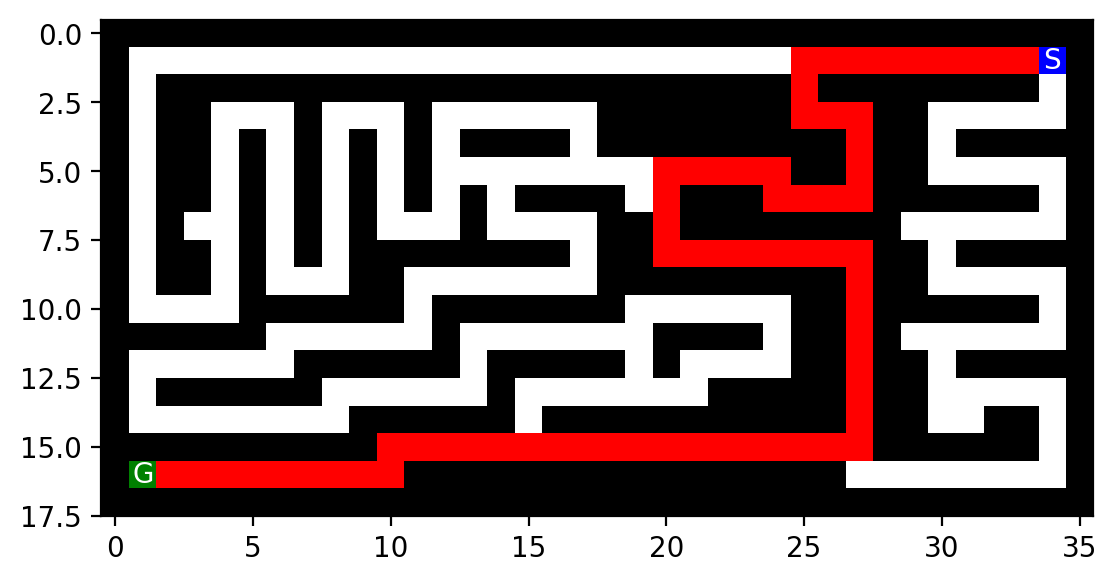

Completed dfs on medium maze


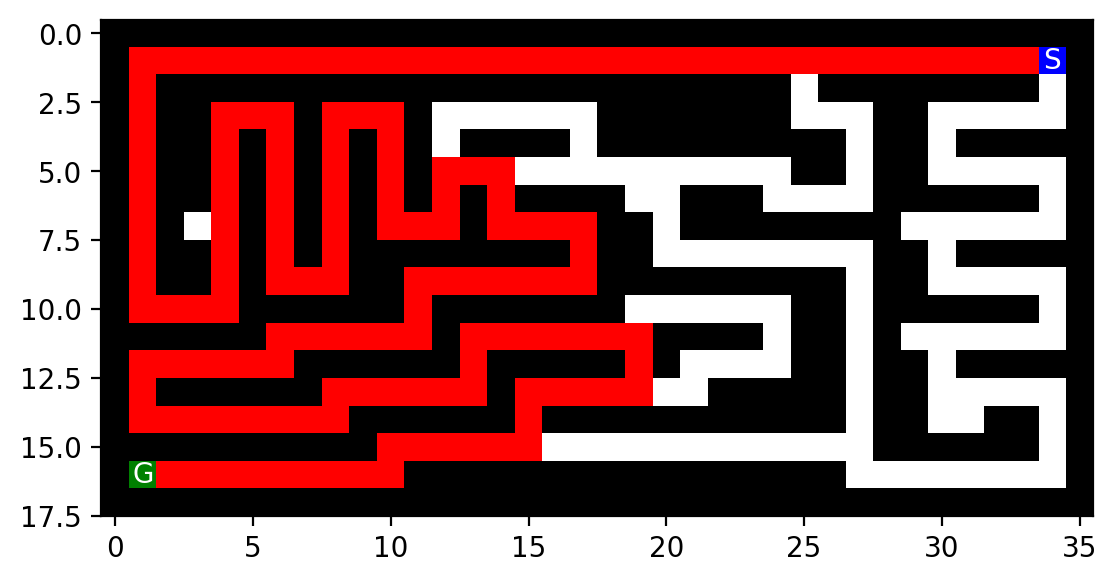

Completed gbfs on medium maze


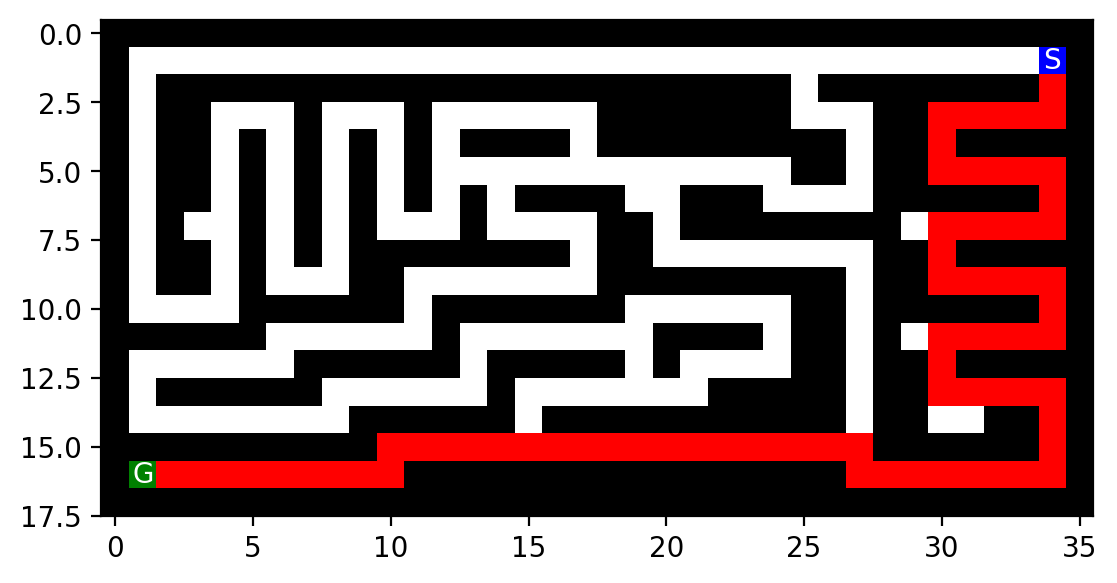

Completed astar on medium maze


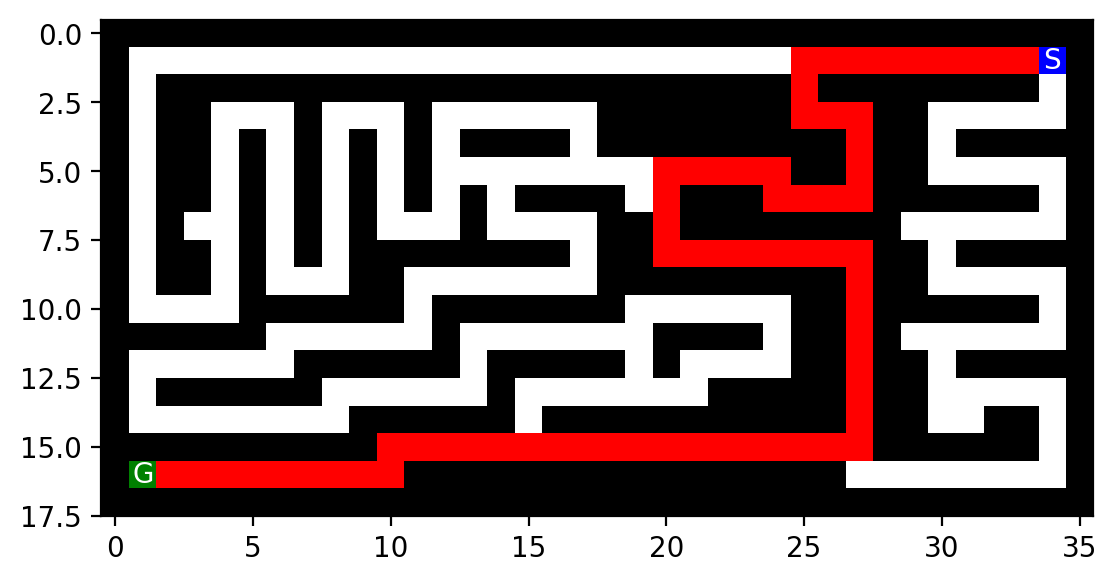

Completed bfs on large maze


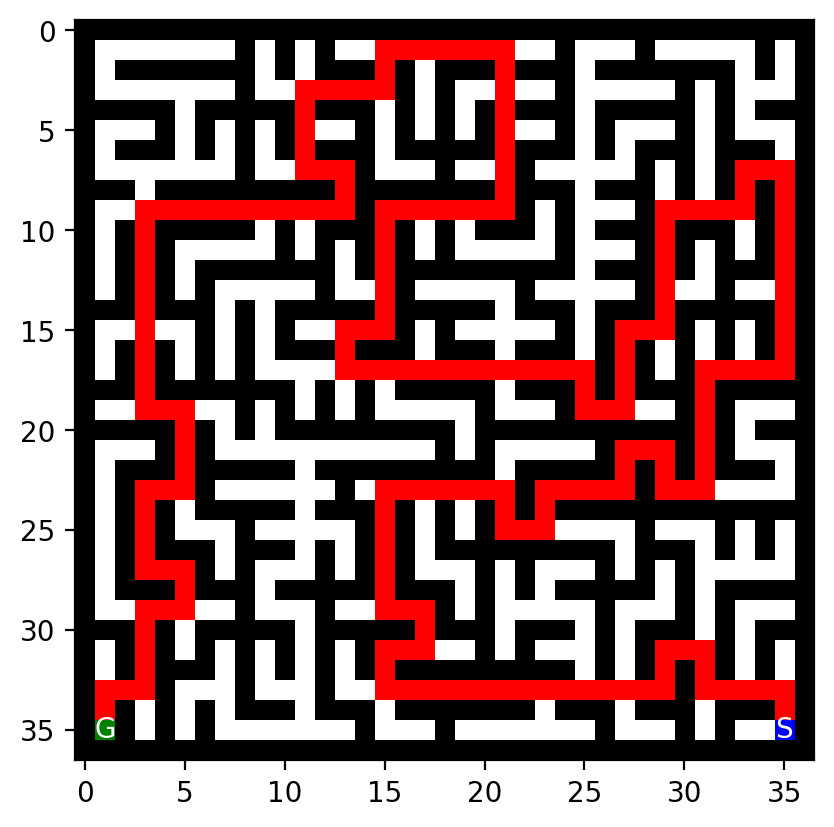

Completed dfs on large maze


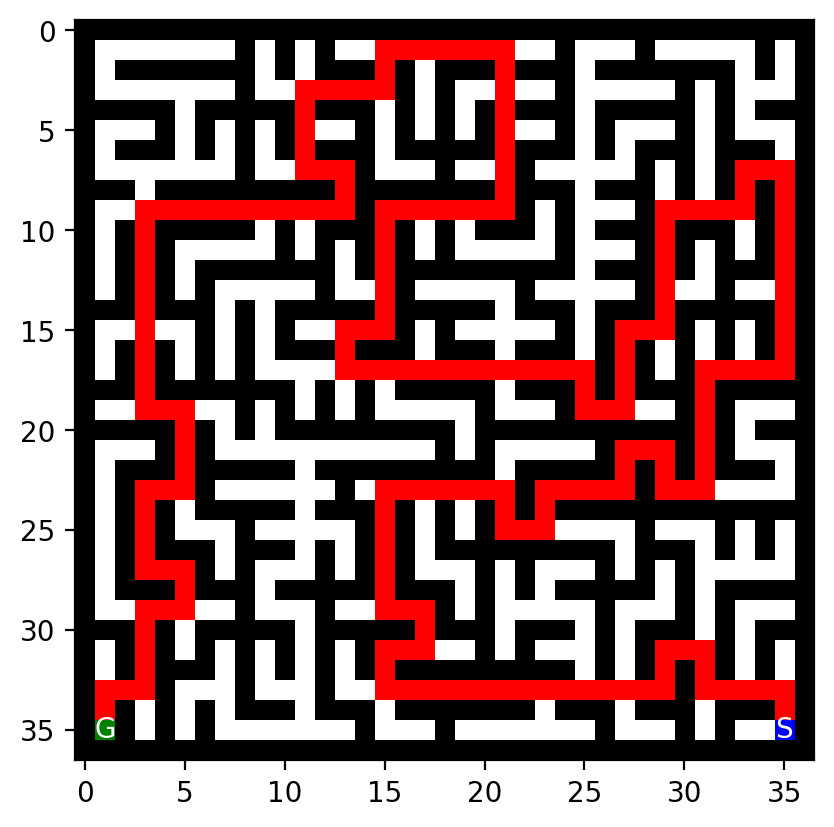

Completed gbfs on large maze


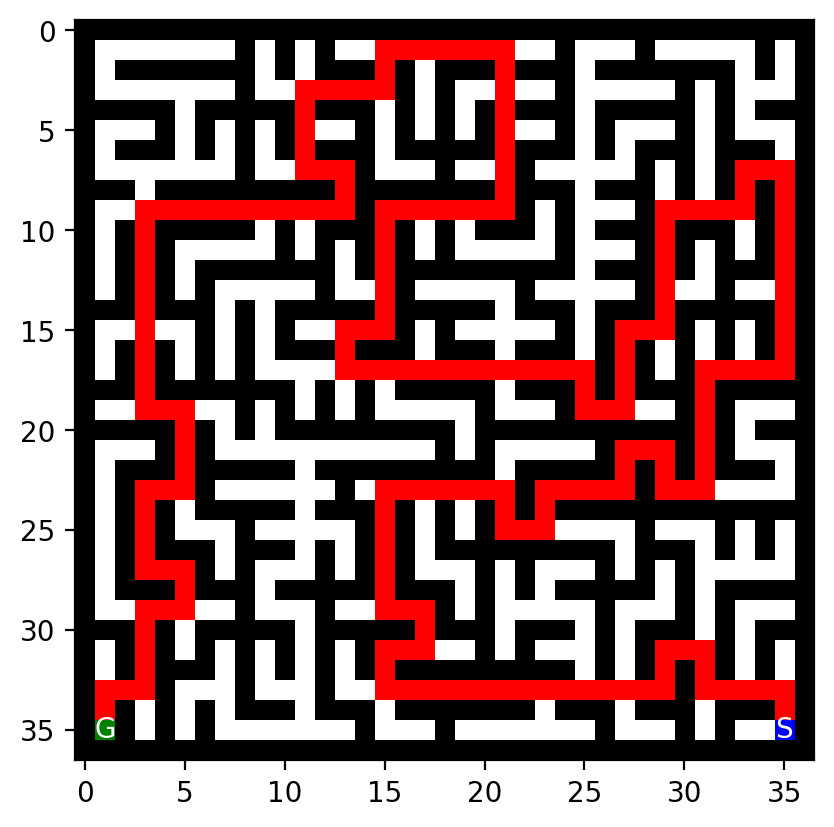

Completed astar on large maze


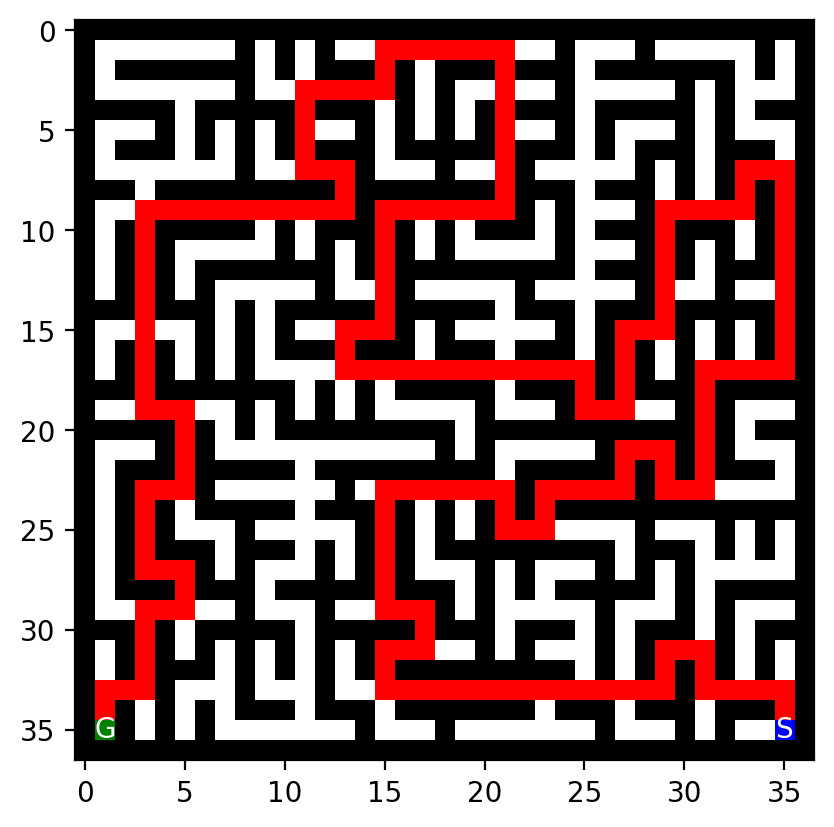

Completed bfs on loops maze


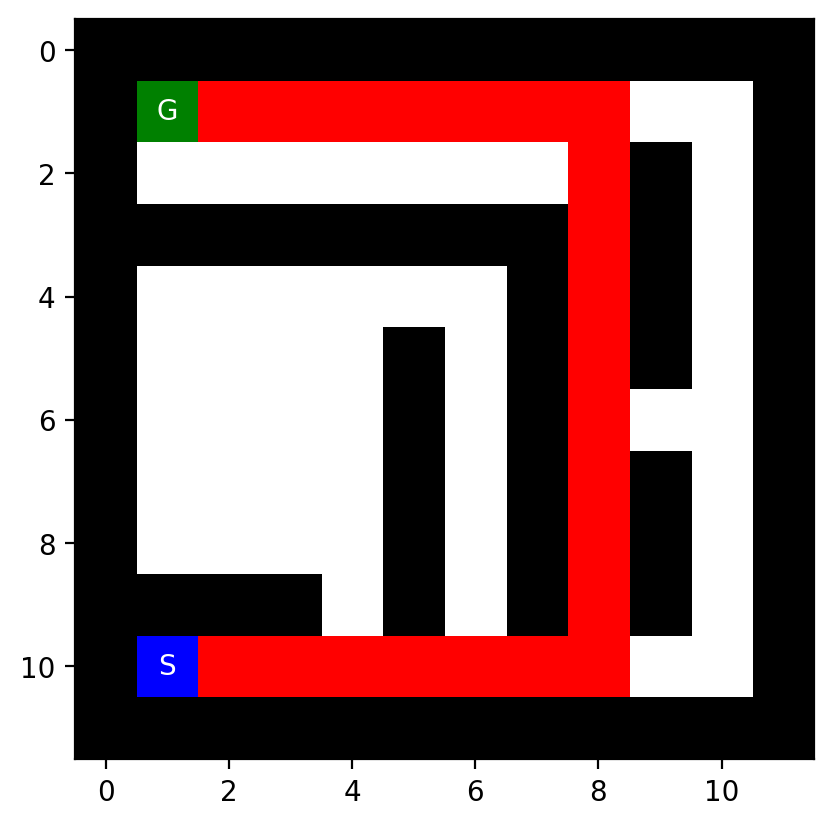

Completed dfs on loops maze


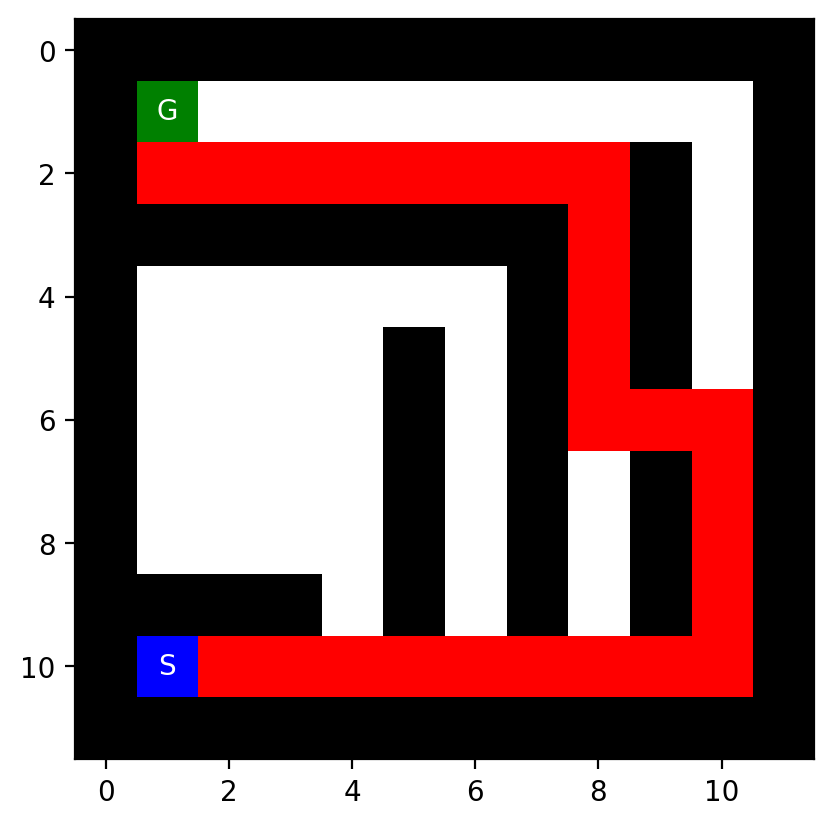

Completed gbfs on loops maze


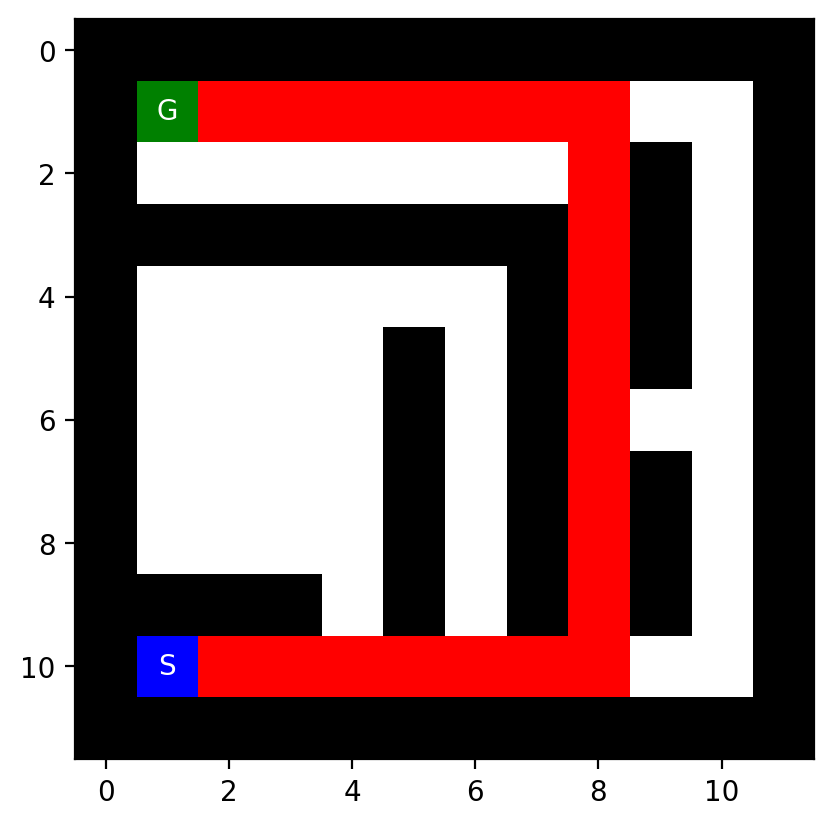

Completed astar on loops maze


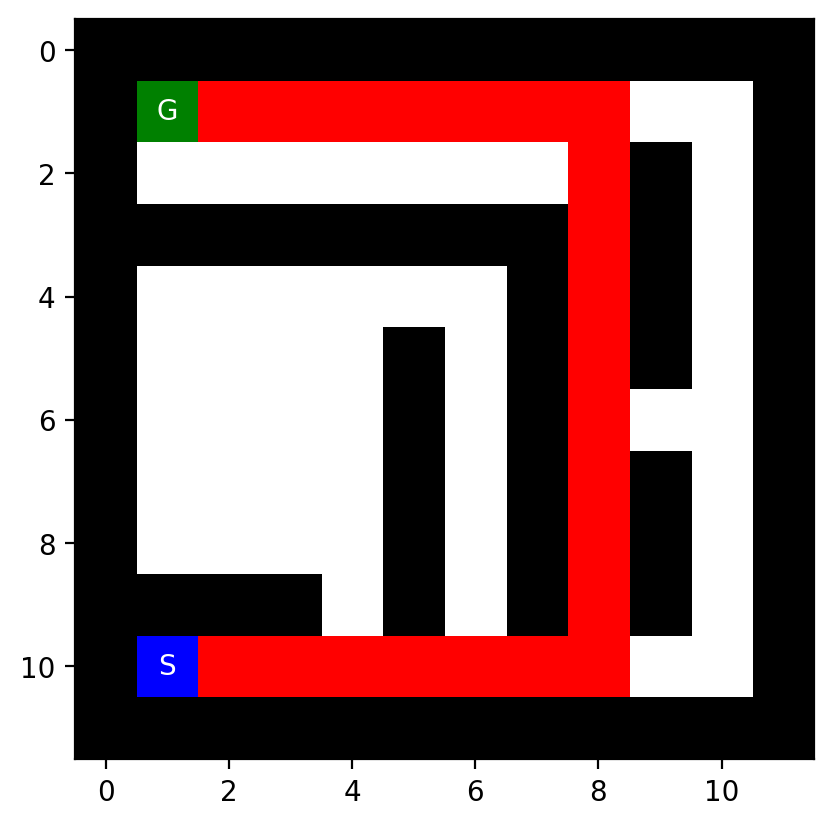

Completed bfs on empty maze


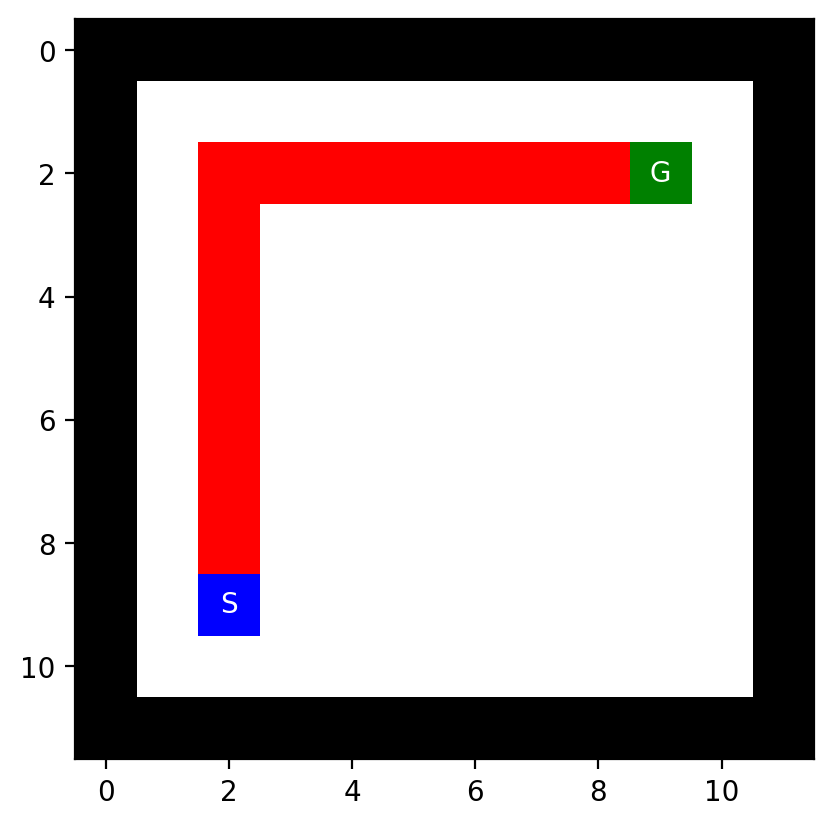

Completed dfs on empty maze


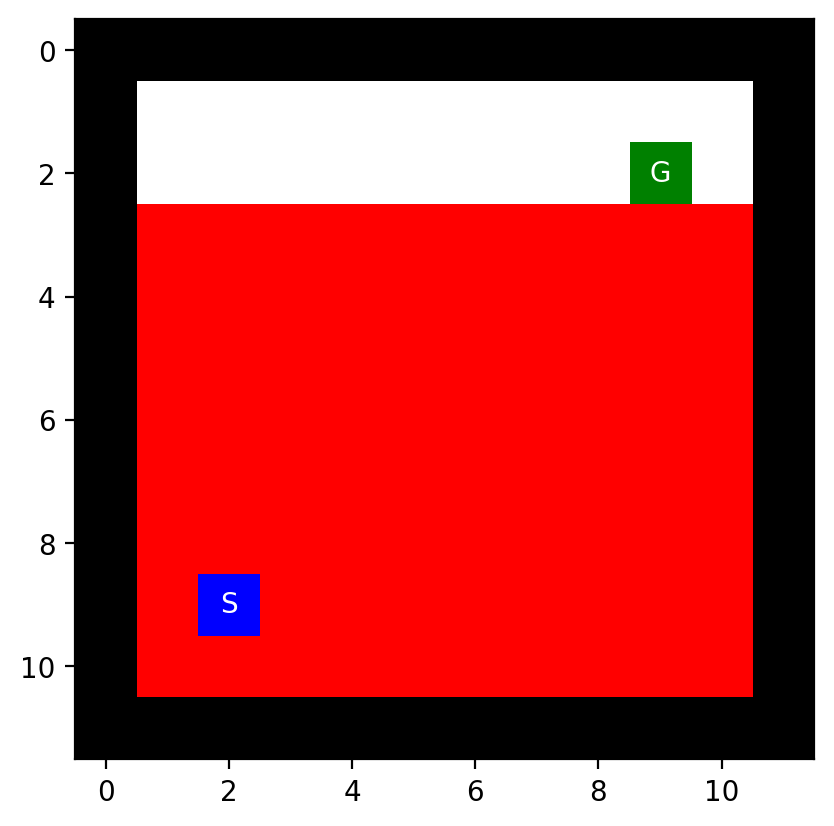

Completed gbfs on empty maze


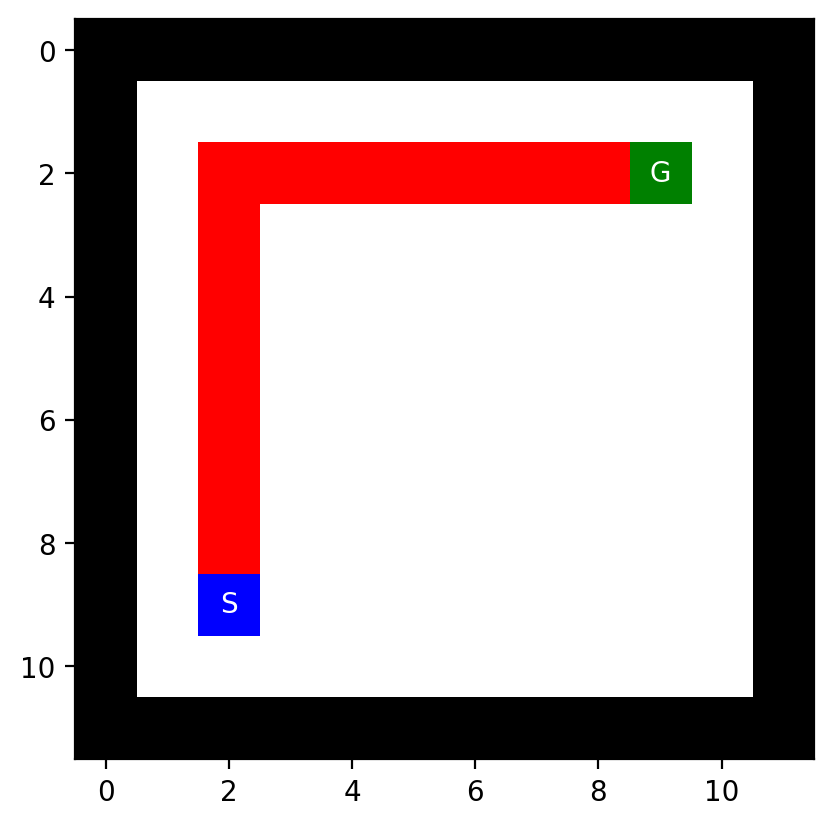

Completed astar on empty maze


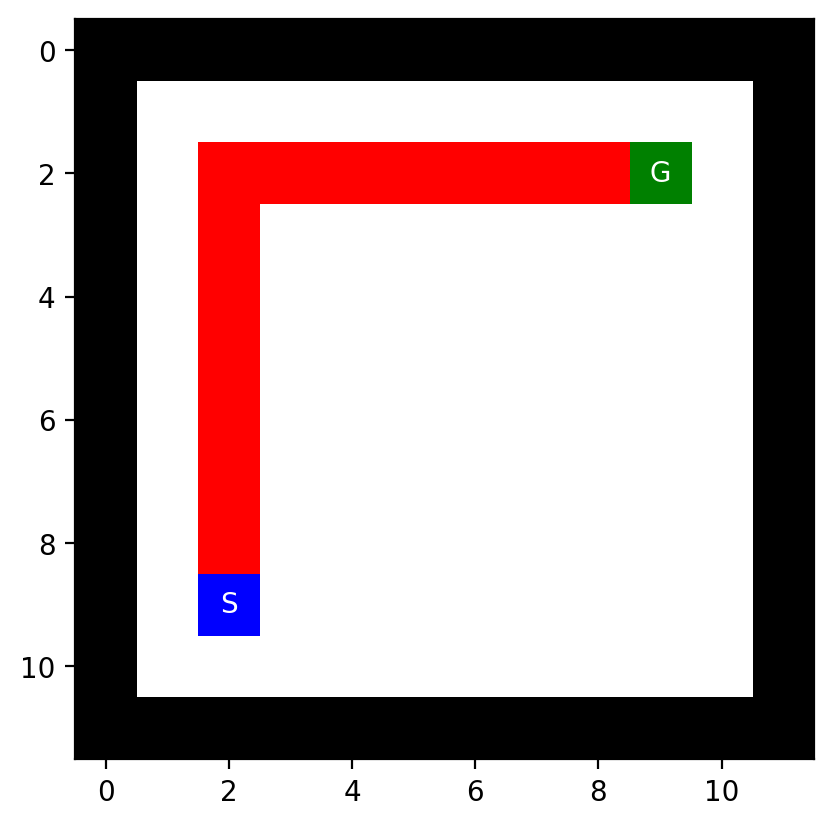

Completed bfs on empty2 maze


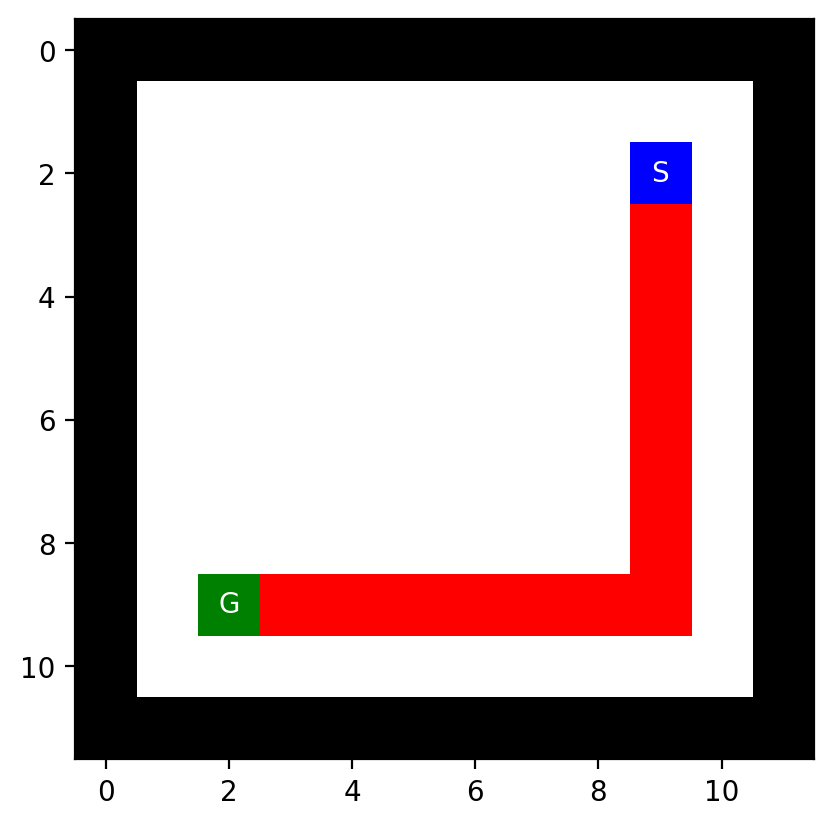

Completed dfs on empty2 maze


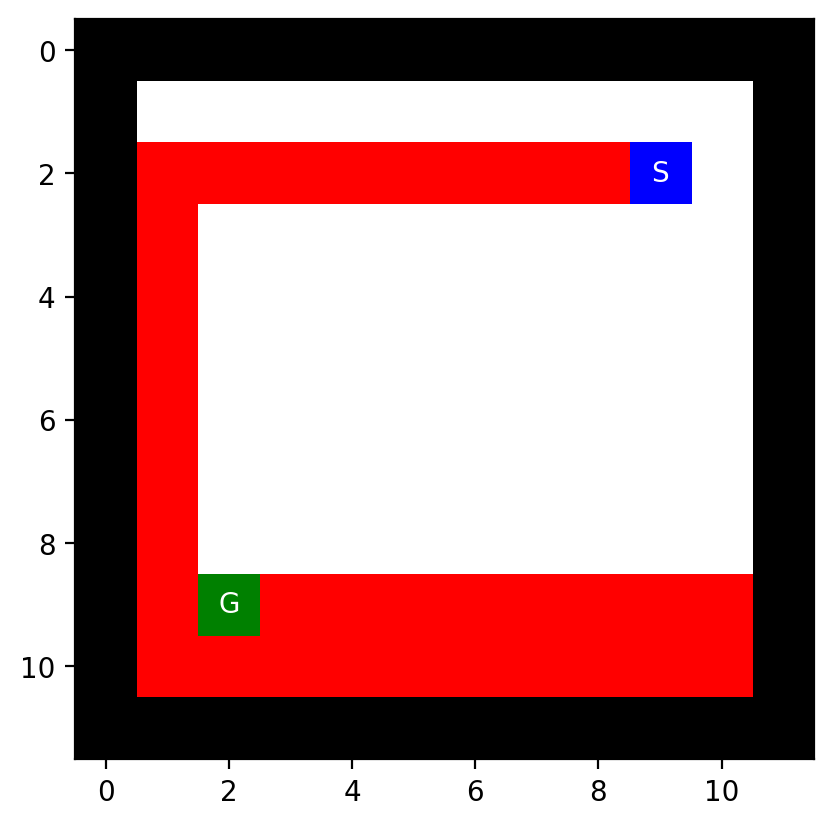

Completed gbfs on empty2 maze


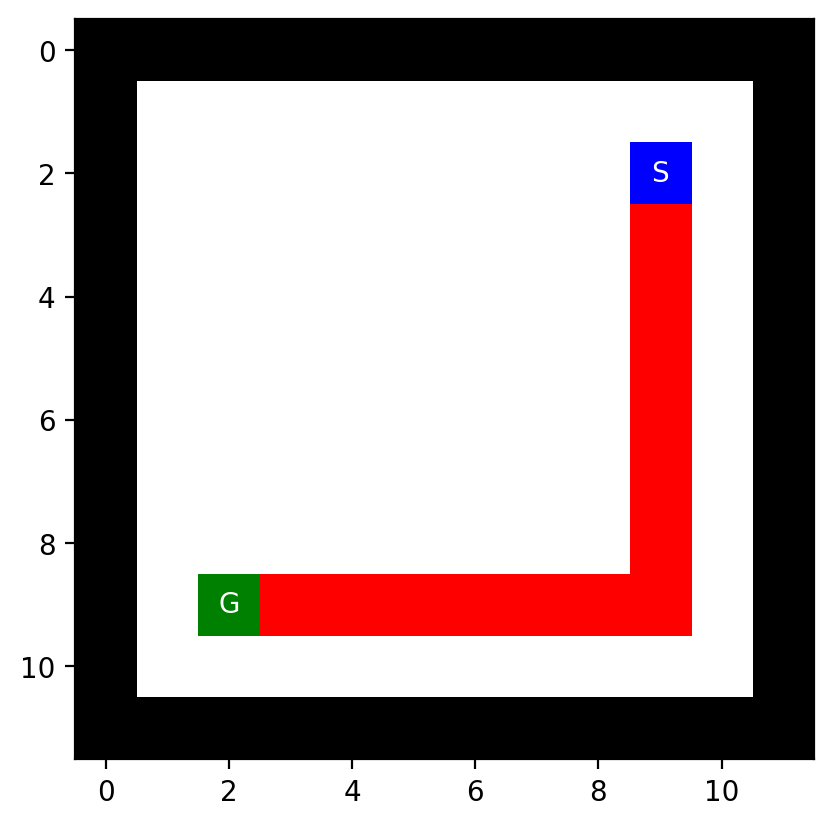

Completed astar on empty2 maze


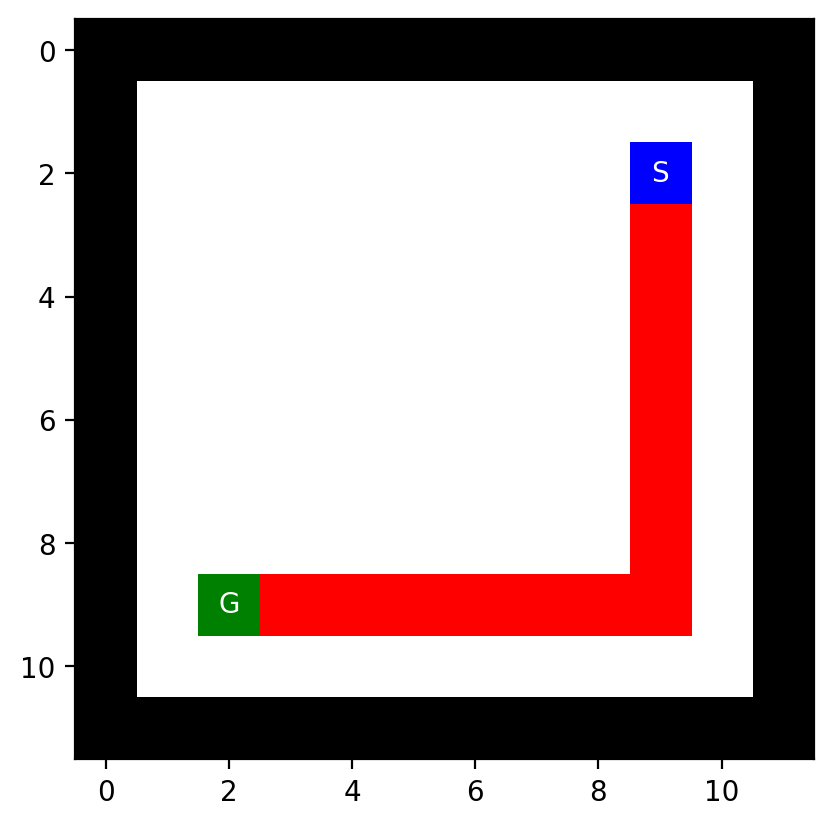

Completed bfs on open maze


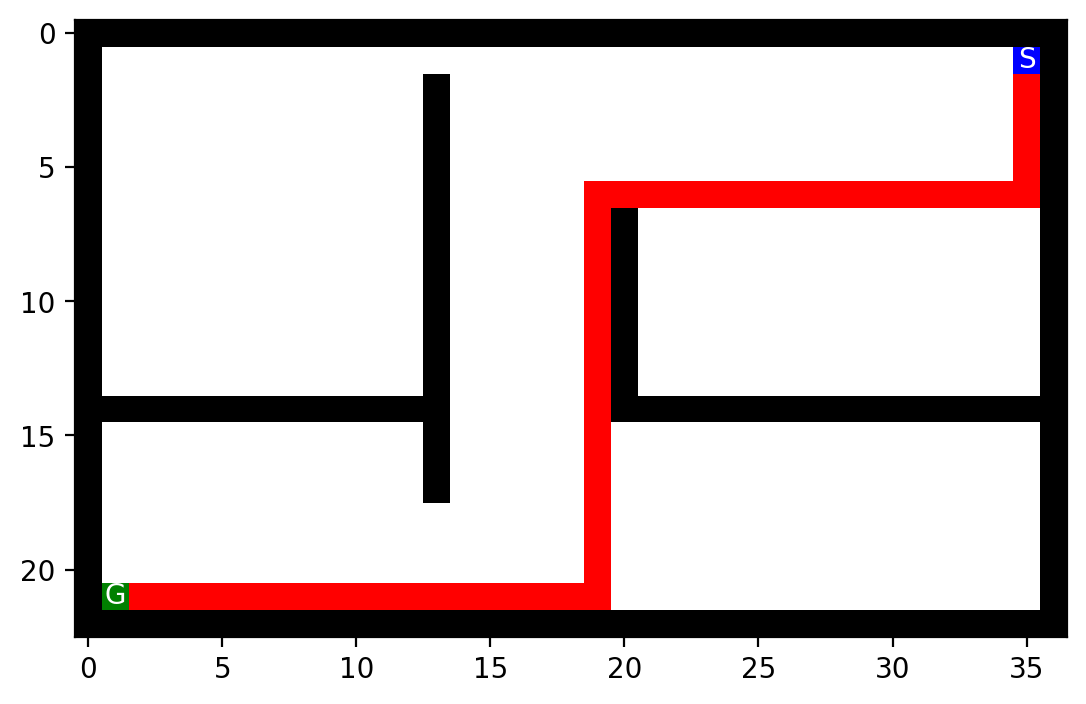

Completed dfs on open maze


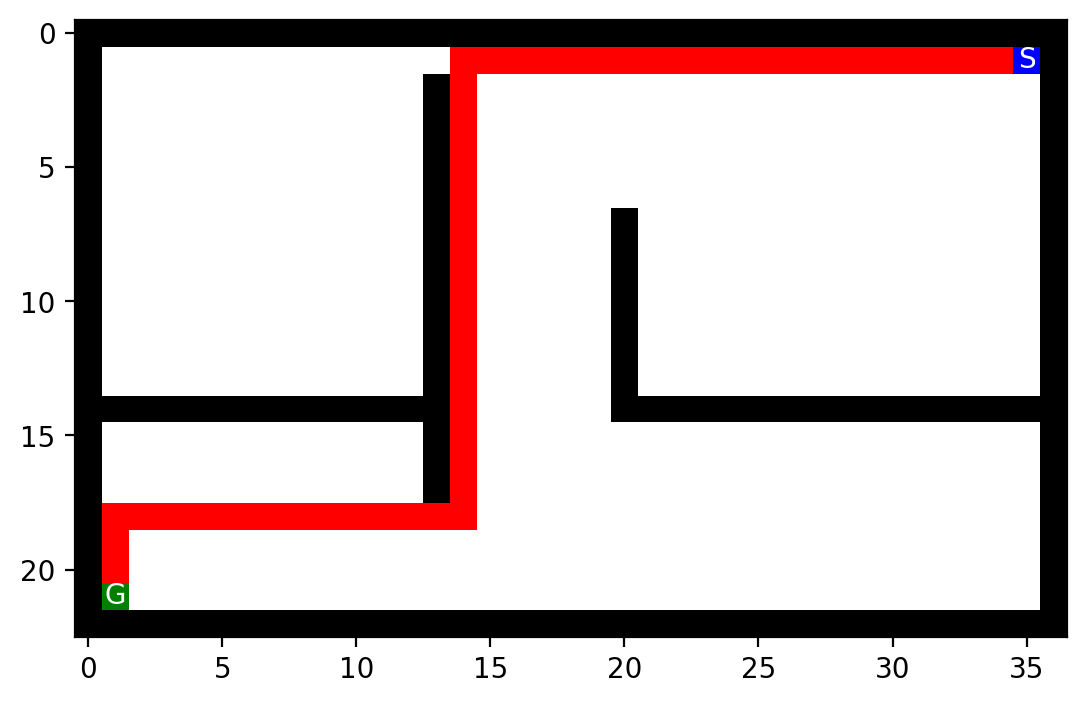

Completed gbfs on open maze


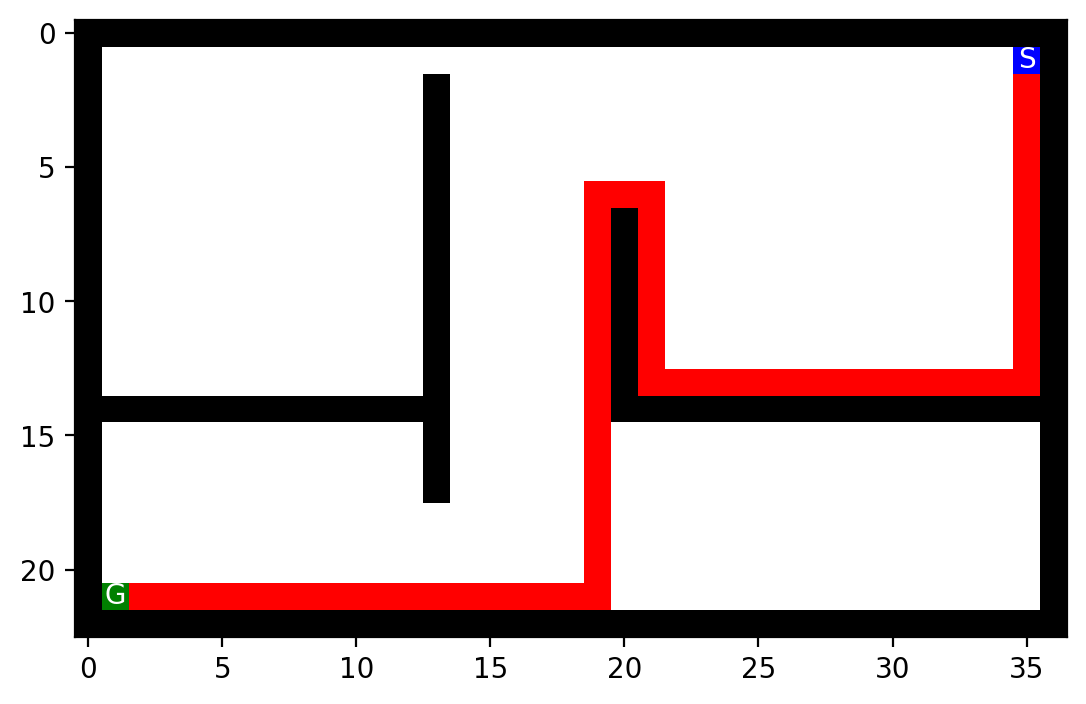

Completed astar on open maze


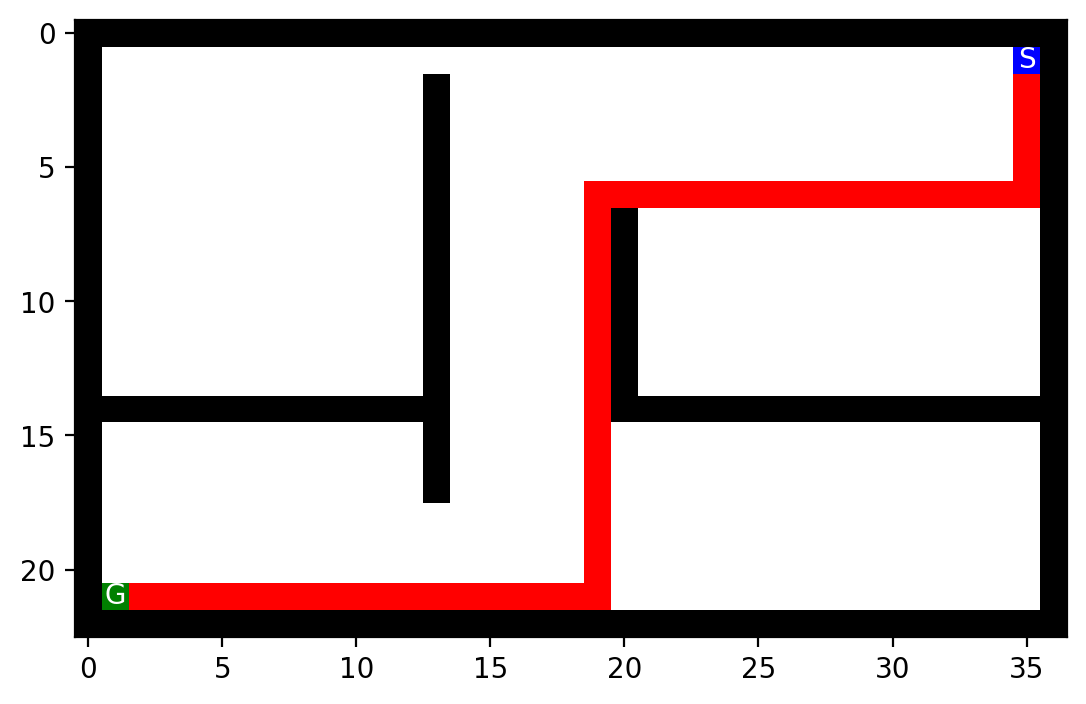

Completed bfs on L maze


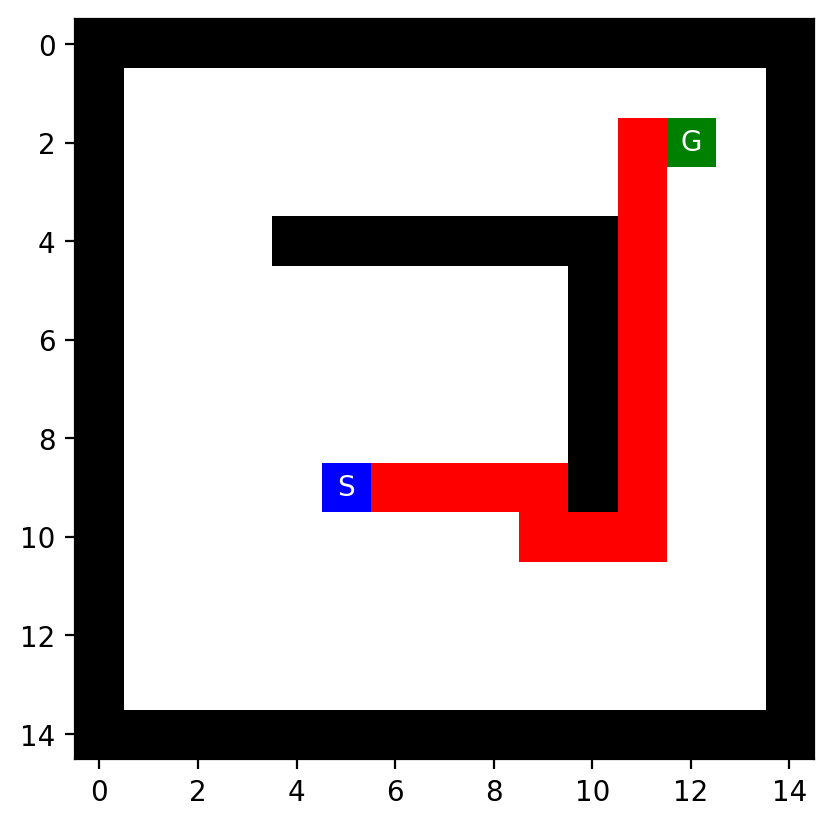

Completed dfs on L maze


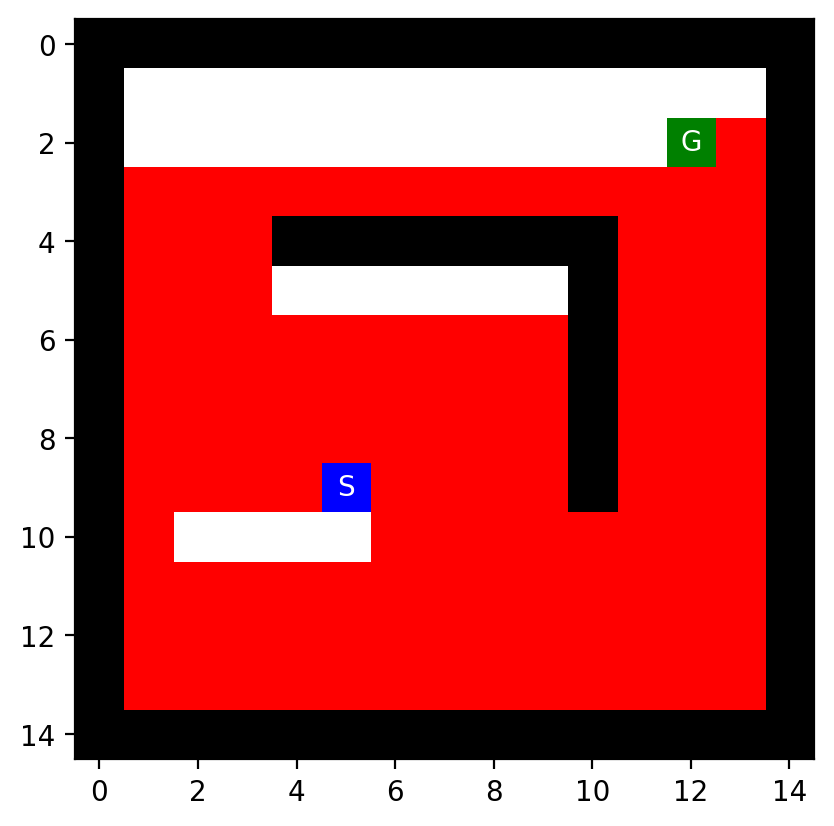

Completed gbfs on L maze


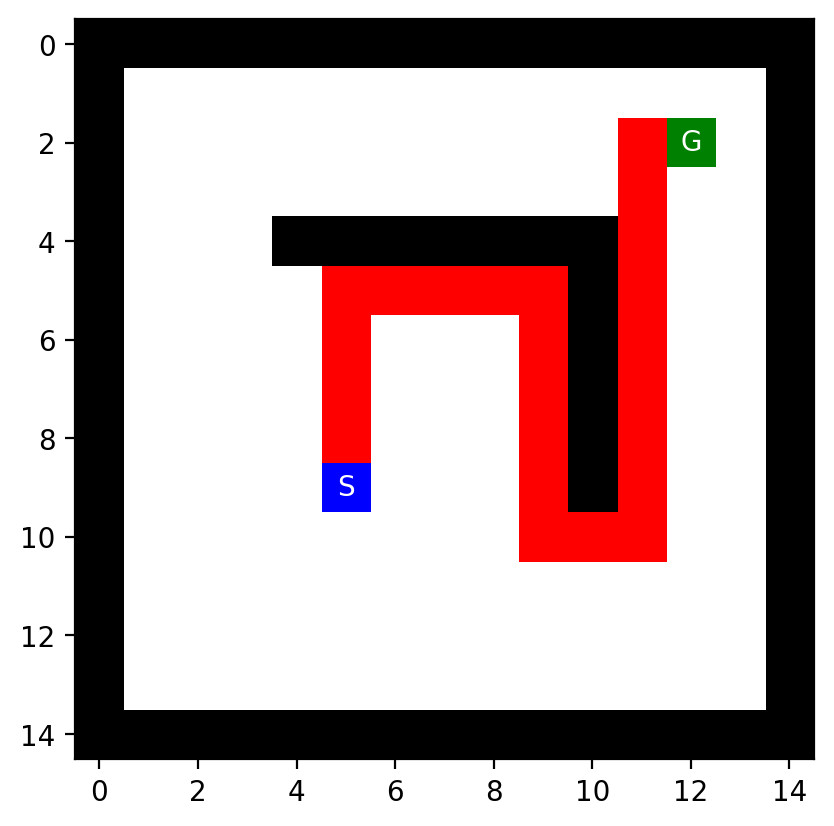

Completed astar on L maze


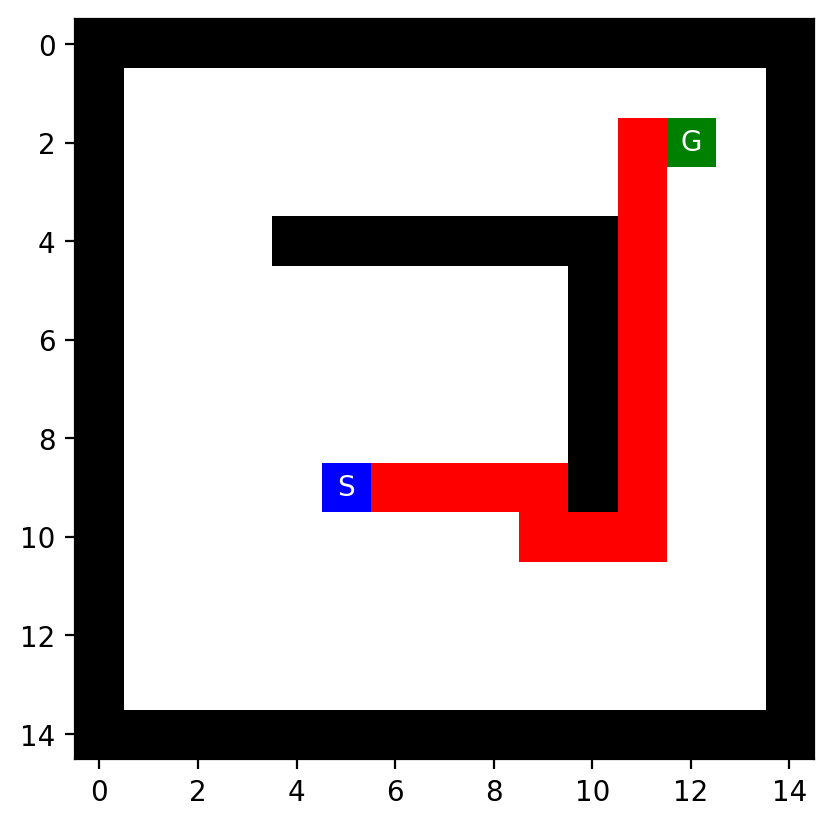

In [181]:
import matplotlib.pyplot as plt
import time

# one bucket per maze key and algorithm
runs =1
for maze_key, maze_path in maze_files.items():
    with open(maze_path, "r") as f:
        maze_str = f.read()
    maze = mh.parse_maze(maze_str)

    for algorithm in algorithms:
        for i in range(runs):
            match algorithm:
                case "bfs":
                    path, cost, expanded, depth, frontier, memory, solution = breadth_first_search(maze)
                case "dfs":
                    path, cost, expanded, depth, frontier, memory, solution = depth_first_search(maze)
                case "gbfs":
                    path, cost, expanded, depth, frontier, memory, solution = greedy_best_first_search(maze)
                case "astar":
                    path, cost, expanded, depth, frontier, memory, solution = a_star_search(maze)
        print(f"Completed {algorithm} on {maze_key} maze")
        show_final_from_path(maze,solution)            


   